
## Making Characters Count

This notebook contains a first exploration of the Middle Dutch Herne manuscripts. The data is available on [Zenodo](https://zenodo.org/records/10005366).

Reference: (Haverals, W., & Kestemont, M. (2023). The Middle Dutch Manuscripts Surviving from the Carthusian Monastery of Herne (14th century) (Camready; rc0-0, with pagexml, code, spreadsheets) [Data set]. Computational Humanities Research Conference (CHR), Paris. Zenodo. https://doi.org/10.5281/zenodo.10005366).

### Loading

Loading the needed libraries:

In [1]:
import pandas as pd
import numpy as np
import regex as re

from collections import Counter
from functools import partial

import unicodedata
import grapheme

from sklearn.feature_extraction.text import TfidfVectorizer
import sklearn.preprocessing as preprocessing
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import OneClassSVM
from sklearn.ensemble import RandomForestClassifier

import matplotlib.pyplot as plt
import seaborn as sns

from bokeh.models import HoverTool, ColumnDataSource
from bokeh.plotting import figure, show, output_file, save
from bokeh.io import output_file, show, save, output_notebook
from bokeh.plotting import figure
from bokeh.models import Axis

Loading in the manuscripts, their content and their metadata:

In [2]:
transcriptions = pd.read_excel('data/manuscript_data_metadata.xlsx')

# The id-column is a concatenation of the signature of the codex, the production unit, and the scribe of the unit
transcriptions['id'] = transcriptions['codex_sig'] + '-' + transcriptions['production unit'] + '-' + transcriptions['scribe']
transcriptions.head(5)

,Unnamed: 0,codex_sig,transkribuspage,image_filename,page_xml_filename,image_width,image_height,region_type,coordinates,fraction,...,content,language,scribe,production unit,local Herne product,date,translator,transcription,HTR-model used,id
0,0,Brussels KBR 1805-1808,7,0007_KBR_1805-08_1r.tiff,0007_KBR_1805-08_1r.xml,5186,7123,header,"1405,478 3598,478 3598,721 1405,721",0.01,...,proloog,middledutch,a,I,yes,1400,bibletranslator,GT,NaN,Brussels KBR 1805-1808-I-a
1,1,Brussels KBR 1805-1808,7,0007_KBR_1805-08_1r.tiff,0007_KBR_1805-08_1r.xml,5186,7123,paragraph,"1359,751 3792,751 3792,2645 1359,2645",0.12,...,proloog,middledutch,a,I,yes,1400,bibletranslator,GT,NaN,Brussels KBR 1805-1808-I-a
2,2,Brussels KBR 1805-1808,8,0008_KBR_1805-08_1v.tiff,0008_KBR_1805-08_1v.xml,5186,7123,paragraph,"1736,658 3985,658 3985,1643 1736,1643",0.06,...,proloog,middledutch,a,I,yes,1400,bibletranslator,GT,NaN,Brussels KBR 1805-1808-I-a
3,3,Brussels KBR 1805-1808,8,0008_KBR_1805-08_1v.tiff,0008_KBR_1805-08_1v.xml,5186,7123,marginalia,"2414,1705 4016,1705 4016,1851 2414,1851",0.01,...,proloog,middledutch,a,I,yes,1400,bibletranslator,GT,NaN,Brussels KBR 1805-1808-I-a
4,4,Brussels KBR 1805-1808,9,0009_KBR_1805-08_2r.tiff,0009_KBR_1805-08_2r.xml,5186,7123,paragraph,"859,5840 847,5678 835,5462 781,4838 751,4480 7...",0.23,...,dialogenGreg1_3,middledutch,α,I,yes,1395,bibletranslator,GT,NaN,Brussels KBR 1805-1808-I-α


In the course of the notebook, some bar plots show up to give more insight on the statistics of the corpus. These are all summarized in tables 1 and 2 in the chapter. When such a plot gets made, we will identify it as such by stating [TABLE].

{'α': 9, 'β': 3, 'γ': 1, 'γ?': 1, 'ε': 1}


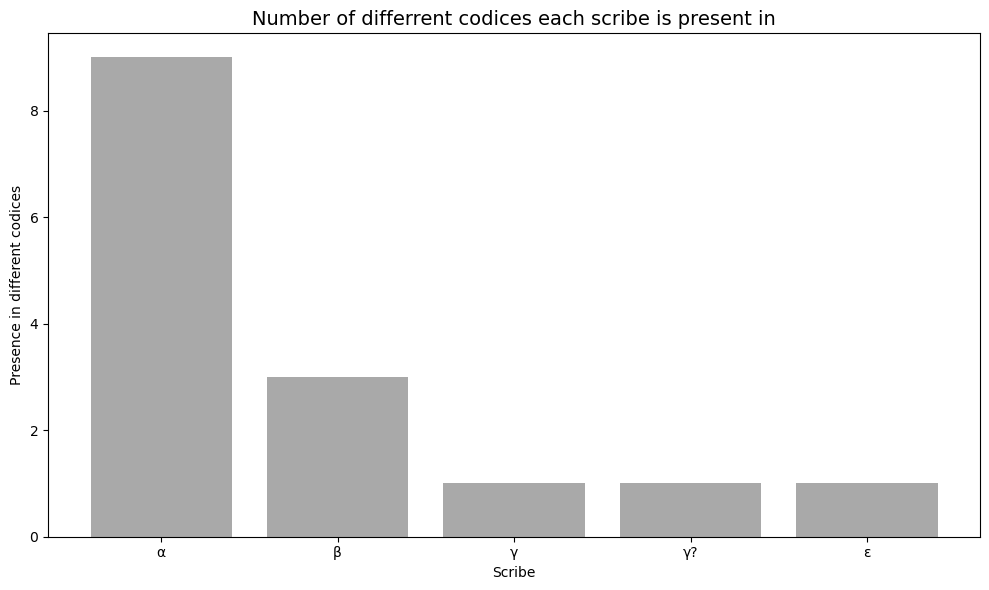

In [3]:
# [TABLE 2]

# Creating a bar plot that shows the number of different codices each scribe is present in

# Group by scribe and count unique codices
desired_scribes = ['α', 'β', 'γ', 'γ?', 'ε' ]
scribe_counts = transcriptions.groupby('scribe')['codex_sig'].nunique()
scribe_counts = scribe_counts.sort_values(ascending=False)
filtered_scribe_counts = scribe_counts[scribe_counts.index.isin(desired_scribes)]
print(dict(filtered_scribe_counts))

# Create bar plot
plt.figure(figsize=(10, 6)) 
plt.bar(filtered_scribe_counts.index, filtered_scribe_counts.values, color='darkgray')

# Add labels
plt.xlabel('Scribe')
plt.ylabel('Presence in different codices')
plt.title('Number of differrent codices each scribe is present in', fontsize=14)

# Increase readability
plt.tight_layout()
plt.show()


In [4]:
# Group by scribe and get unique codex_sig for each
unique_codex_sigs_per_scribe = transcriptions.groupby('scribe')['codex_sig'].unique()

# Print the result
for scribe, codex_sigs in unique_codex_sigs_per_scribe.items():
    print(f"Scribe: {scribe}, Codex Signatures: {codex_sigs}")

Scribe: A, Codex Signatures: ['Brussels KBR 2877-78' 'Brussels KBR 2879-80' 'Brussels KBR 2979'
 'Brussels KBR 394-98' 'Ghent UB 941' 'Paris Bibliothèque Mazarine 920'
 'Saint Petersburg BAN O 256' 'Vienna ÖNB 12.857' 'Vienna ÖNB 12.905']
Scribe: A-B, Codex Signatures: ['Brussels KBR 2879-80' 'Ghent UB 941' 'Saint Petersburg BAN O 256']
Scribe: B, Codex Signatures: ['Brussels KBR 2879-80' 'Brussels KBR 2979' 'Brussels KBR 394-98'
 'Ghent UB 941' 'Saint Petersburg BAN O 256' 'Vienna ÖNB 12.905']
Scribe: B-C, Codex Signatures: ['Brussels KBR 2879-80']
Scribe: B-G, Codex Signatures: ['Saint Petersburg BAN O 256']
Scribe: C, Codex Signatures: ['Brussels KBR 2879-80' 'Brussels KBR 2979'
 "Paris Bibliothèque de l'Arsenal 8224" 'Vienna ÖNB 12.857']
Scribe: D, Codex Signatures: ['Brussels KBR 1805-1808']
Scribe: E, Codex Signatures: ['Brussels KBR 2979']
Scribe: G, Codex Signatures: ['Paris Bibliothèque Mazarine 920' 'Saint Petersburg BAN O 256']
Scribe: K, Codex Signatures: ['Paris Bibliothèq

We merge together all text from the same production units.

In [5]:
units = []
plain_char = re.compile("[A-Za-z]+")

for prod_unit_id, prod_unit in transcriptions.groupby('id'):
    prod_unit = prod_unit.sort_values('transkribuspage')
    prod_unit = prod_unit[~prod_unit['text'].isna()]
    if not len(prod_unit):
        continue
    text = ' '.join(t for t in prod_unit['text']) # join all texts together (for the same prod_unit)
    text = ' '.join(text.strip().split())
    
    date = prod_unit.sample(1)['date'].values[0]
    scribe = prod_unit.sample(1)['scribe'].values[0]
    sig = prod_unit.sample(1)['codex_sig'].values[0]
    content = '<UNK>'
    try:
        content = ' - '.join(Counter(prod_unit['content']))
    except:
        pass
    
    try:
        if plain_char.fullmatch(scribe):
            scribe = sig + '-' + scribe
    except TypeError:
        scribe = '<UNK>'
        
    translator = prod_unit.sample(1)['translator'].values[0]
    units.append((prod_unit_id, date, text, scribe, sig, prod_unit_id, translator, content))

H = pd.DataFrame(units, columns=['pu', 'date', 'text', 'scribe', 'signature', 'id', 'translator', 'content'])
H

,pu,date,text,scribe,signature,id,translator,content
0,Brussels KBR 1805-1808-I-a,1400,Een voorredene op sinte gregoriꝰ dyalogus DE z...,Brussels KBR 1805-1808-a,Brussels KBR 1805-1808,Brussels KBR 1805-1808-I-a,bibletranslator,proloog
1,Brussels KBR 1805-1808-I-α,1395,Hier beghint een voʼredene op .Sʼ. gᵉgorius dy...,α,Brussels KBR 1805-1808,Brussels KBR 1805-1808-I-α,bibletranslator,dialogenGreg1_3
2,Brussels KBR 1805-1808-II-D,1395,Hiʼ begēt de pierde boec vā gᵉgerna ¶ Dyalogus...,Brussels KBR 1805-1808-D,Brussels KBR 1805-1808,Brussels KBR 1805-1808-II-D,bibletranslator,dialogenGreg4
3,Brussels KBR 1805-1808-II-α,1395,De dʼde boec gaꝫ hiʼ vte Hiʼ volgen dē capitee...,α,Brussels KBR 1805-1808,Brussels KBR 1805-1808-II-α,none,inhoudsopgave
4,Brussels KBR 1805-1808-III-none,1395,DJt boec hoert den bruedʼs vādē goede cloestin...,Brussels KBR 1805-1808-none,Brussels KBR 1805-1808,Brussels KBR 1805-1808-III-none,none,none
...,...,...,...,...,...,...,...,...
118,Vienna ÖNB 65-I-a,1375-1400,liber iste ꝑtinet ad cenob sā pauli zonia Dor...,Vienna ÖNB 65-a,Vienna ÖNB 65,Vienna ÖNB 65-I-a,NaN,note
119,Vienna ÖNB 65-I-γ,1375-1400,‡ d blie die pase on heeren ihoes so voerga en...,γ,Vienna ÖNB 65,Vienna ÖNB 65-I-γ,NaN,TOC
120,Vienna ÖNB 65-II-α,1375-1400,huiꝰ lcōt corrigat librū qui valde īcorrectꝰ ē...,α,Vienna ÖNB 65,Vienna ÖNB 65-II-α,NaN,horlogium
121,Vienna ÖNB 65-III-γ,1375-1400,vᵃ De wijsheit . Dat en mach niet sijn . Noch ...,γ,Vienna ÖNB 65,Vienna ÖNB 65-III-γ,NaN,horlogium


{'α': 32, 'β': 4, 'γ': 3, 'ε': 1, 'γ?': 1}


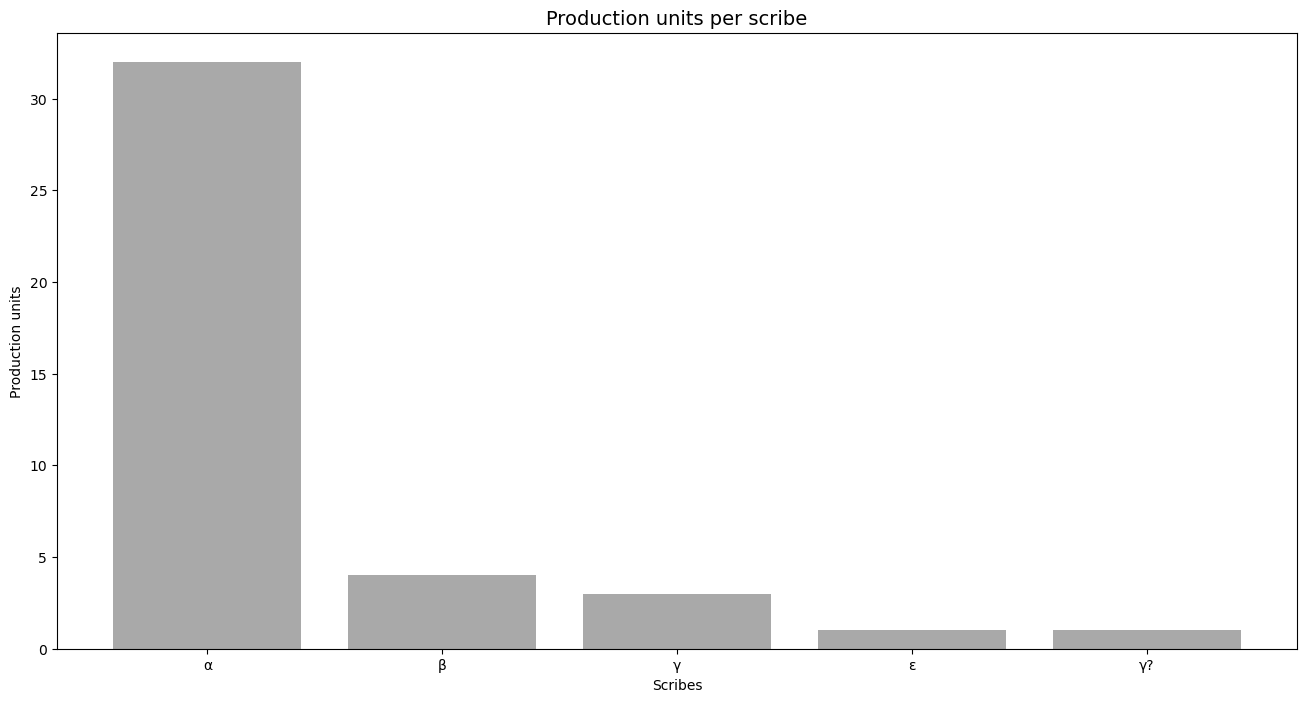

In [6]:
# [TABLE 2]

# Creating a bar plot with production units per scribe

# Define the desired scribes
desired_scribes = ['α', 'β', 'γ', 'γ?', 'ε']

# Filter the DataFrame for the desired scribes
filtered_data = H[H['scribe'].isin(desired_scribes)]

# Create a bar plot with production units per scribe
pu_per_scribe = dict(filtered_data['scribe'].value_counts())
print(pu_per_scribe)

# Create plot
plt.figure(figsize=(16, 8))
plt.bar(pu_per_scribe.keys(), pu_per_scribe.values(), color='darkgray')

# Adding labels
plt.xlabel('Scribes')
plt.ylabel('Production units')
plt.title('Production units per scribe', fontsize=14)

# Increase readability
plt.xticks(fontsize=10)

plt.show()

In [7]:
# If a date is approximated (f.e. 1325-1350), we have to convert it 
# to one single year in order to work with it. Accordingly, we calculate
# the mean and store it in the 'num_date'-column

num_dates = []

for d in H['date']:
    if d in ('unknown', 'no', 'none'):
        d = None
    else:
        try:
            d = int(d)
        except ValueError:
            if '-' in d:
                d1, d2 = d.split('-')
                d1, d2 = int(d1), int(d2)
                d = d1 + ((d2 - d1) / 2)
    num_dates.append(d)
    
H['num_date'] = num_dates
H['length'] = H['text'].str.len()
H = H.sort_values('num_date')
H

,pu,date,text,scribe,signature,id,translator,content,num_date,length
82,Saint Petersburg BAN O 256-II-G,1325-1350,es and net aeroeg ē en wna M8 Sadoch ghebaer a...,Saint Petersburg BAN O 256-G,Saint Petersburg BAN O 256,Saint Petersburg BAN O 256-II-G,NaN,evangMath,1337.5,108874
80,Saint Petersburg BAN O 256-I-B,1325-1350,Vandē i maghede . Osluestʼs dach mᵗ xxiiij. Wa...,Saint Petersburg BAN O 256-B,Saint Petersburg BAN O 256,Saint Petersburg BAN O 256-I-B,NaN,perikopen,1337.5,4543
81,Saint Petersburg BAN O 256-I-II-B-G,1325-1350,E nedʼ gaende . Op alre heilighē . dʼ mᵗ .v. ...,B-G,Saint Petersburg BAN O 256,Saint Petersburg BAN O 256-I-II-B-G,NaN,perikoken-evangMath,1337.5,1537
26,Brussels KBR 2879-80-III-C,1325-1350,Ay Ay edele vol redenē waer moe- ghedi dueren ...,Brussels KBR 2879-80-C,Brussels KBR 2879-80,Brussels KBR 2879-80-III-C,none,HadLied - HadLied-HadMeng - HadMeng,1337.5,118389
25,Brussels KBR 2879-80-III-B-C,1325-1350,mi dat ic di ꝟwinne Jn dine onuʼ- wonnene crac...,B-C,Brussels KBR 2879-80,Brussels KBR 2879-80-III-B-C,none,HadLied,1337.5,2264
...,...,...,...,...,...,...,...,...,...,...
76,Paris Bibliothèque de l'Arsenal 8224-none-none,none,d gostste Nut Jaer ons hʼoerdei gh ei oegod b...,Paris Bibliothèque de l'Arsenal 8224-none,Paris Bibliothèque de l'Arsenal 8224,Paris Bibliothèque de l'Arsenal 8224-none-none,NaN,schenkingsnotitie,NaN,1093
77,Paris Bibliothèque de l'Arsenal 8224-none-unknown,none,de on Aʼsic sommē frusten . cfit Sn iichul mok...,Paris Bibliothèque de l'Arsenal 8224-unknown,Paris Bibliothèque de l'Arsenal 8224,Paris Bibliothèque de l'Arsenal 8224-none-unknown,NaN,vulgaat,NaN,1711
89,Saint Petersburg BAN O 256-none-none,none,,Saint Petersburg BAN O 256-none,Saint Petersburg BAN O 256,Saint Petersburg BAN O 256-none-none,NaN,none,NaN,0
95,Vienna ÖNB 12.857-none-none,no,. Die .iiij. euangelisten .,Vienna ÖNB 12.857-none,Vienna ÖNB 12.857,Vienna ÖNB 12.857-none-none,NaN,none,NaN,27


In [8]:
# Filters out any short text with a length less than 1000 characters

print(len(H))
H = H[H['length'] > 1000]
print(len(H))

123
92


### Corpus dataframe

Summary of codices and scribal contributions in Middle Dutch manuscripts originating from Herne, as identified by Kwakkel (2002). This table showcases the contributions of the main scribes α, β, γ, and ε across various codices within the corpus

! Caution -- contents have to be manually added (now, just an empty placeholder column) + some manuscripts are photogrphed as bifolia, so they have to be counted as two pages!! This multiplication has to happen afterwards (e.g Saint Petersburg BAN O 256 = 416 pages etc.)

In [9]:
# [TABLE 2]

# retain rows where language is middledutch
transcriptions = transcriptions[transcriptions['language'] == 'middledutch']

# desired scribes
desired_scribes = ['α', 'β', 'γ', 'γ?',  'ε']

# ensure 'text' column contains only strings
transcriptions['text'] = transcriptions['text'].fillna('').astype(str)

# group by codex and scribe
grouped = transcriptions.groupby(['codex_sig', 'scribe'])

# metrics for each group
size = grouped['transkribuspage'].nunique()
words = grouped['text'].apply(lambda x: len(' '.join(x).split()))
unique_words = grouped['text'].apply(lambda x: len(set(' '.join(x).split())))

# df
codex_scribe_data = pd.DataFrame({
    'Codex': size.index.get_level_values(0),
    'Scribe(s)': size.index.get_level_values(1),
    'Middle Dutch Pages': size.values,
    'Main Content': '',  
    'Words': words.values,
    'Unique Words': unique_words.values
})

# separate desired scribes and others
desired_scribe_data = codex_scribe_data[codex_scribe_data['Scribe(s)'].isin(desired_scribes)]
other_scribe_data = codex_scribe_data[~codex_scribe_data['Scribe(s)'].isin(desired_scribes)]

# agg data for 'other' scribes
other_scribe_aggregated = other_scribe_data.groupby('Codex').agg({
    'Middle Dutch Pages': 'sum',
    'Words': 'sum',
    'Unique Words': 'sum'
}).reset_index()
other_scribe_aggregated['Scribe(s)'] = 'Other'

# combine the data
combined_data = pd.concat([desired_scribe_data, other_scribe_aggregated], ignore_index=True)

# sort by 'Codex'
sorted_combined_data = combined_data.sort_values(by='Codex')

sorted_combined_data


,Codex,Scribe(s),Middle Dutch Pages,Main Content,Words,Unique Words
0,Brussels KBR 1805-1808,α,84,,61332,9057
1,Brussels KBR 1805-1808,β,7,,5558,2219
15,Brussels KBR 1805-1808,Other,41,NaN,28613,5931
2,Brussels KBR 2485,β,135,,27442,4744
3,Brussels KBR 2849-51,α,693,,154399,19718
16,Brussels KBR 2877-78,Other,330,NaN,90181,12481
17,Brussels KBR 2879-80,Other,202,NaN,82113,15267
18,Brussels KBR 2905-09,Other,13,NaN,1078,603
4,Brussels KBR 2905-09,α,200,,46954,8418
19,Brussels KBR 2979,Other,333,NaN,84558,18232


## Cleaning the data

We separate the characters into three categories: (regular) letters, brevigraphs, and punctuation.

In [10]:
# To create the dictionaries with letters, brevigraphs, and punctuation,
# we only use the ground truth transcriptions (not the HTR transcriptions).
# That way, we are sure no artifacts of the model are included.

allowed_chars = ''.join([t for t in transcriptions[transcriptions['transcription'] == 'GT']['text'] if isinstance(t, str)])
allowed_chars = Counter(allowed_chars)
print(allowed_chars)

Counter({' ': 271135, 'e': 219860, 'd': 73315, 't': 72143, 'i': 69659, 'n': 66130, 's': 64767, 'a': 52338, 'h': 47919, 'o': 47395, 'l': 45006, '\n': 44270, 'ē': 44220, 'r': 37091, 'g': 32345, 'c': 32096, 'm': 27462, 'ʼ': 24453, 'u': 20741, 'w': 19797, 'v': 17395, '.': 17330, 'b': 14558, '\ue5dc': 12806, ':': 9737, 'k': 9131, 'ī': 9096, 'ā': 8605, 'p': 8212, 'ꝫ': 7334, 'D': 7083, '-': 6872, 'f': 6047, 'E': 5507, 'ō': 5388, 'j': 4924, 'ᵗ': 3333, '\ue554': 2245, 'W': 2162, 'y': 2087, 'S': 2020, 'x': 1892, 'H': 1796, 'M': 1789, 'A': 1613, 'J': 1586, 'ᵃ': 1491, 'ᵒ': 1400, 'z': 1360, 'ᵉ': 1214, 'V': 1139, 'N': 1125, 'ꝟ': 1098, 'q': 1027, 'O': 880, 'ꝰ': 849, 'G': 821, 'ⁱ': 744, '¶': 737, 'T': 518, 'B': 448, 'ⁿ': 392, '̄': 388, 'ꝑ': 319, '\ue5b8': 307, 'ū': 299, 'ᵛ': 291, '\ue665': 275, 'ꝓ': 247, 'I': 229, 'ᷣ': 214, '⸫': 212, 'L': 183, 'ꝯ': 180, 'C': 176, '‡': 149, '|': 131, '\uf160': 124, 'R': 123, 'Z': 120, '1': 118, 'Ō': 117, 'P': 102, '3': 95, '2': 92, '‸': 81, '4': 71, '6': 53, '᷑': 49, '

In [11]:
plain_char = re.compile("[A-Za-z]+")

# the following characters are also brevigraphs, but we need to add them
# manually, otherwise they're recognised as punctuation
unicode_brevigraphs = [u'\ue5dc', u'\ue554', u'\ue5b8', u'\ue665', u'ᷣ', u'̄', u'᷑',
                  u'\ue74d', u'\ue8e5', u'\ueed7', u'\ue681', u'\ue1dc', u'\ue154']

letters, brevigraphs, punctuation = [], [], []

for g, c in allowed_chars.items():
    # ignore:
    if g.isnumeric():
        continue
    if g.isspace():
        continue
    if plain_char.fullmatch(g):
        letters.append((g, c))
    elif g.isalpha() or g in unicode_brevigraphs:  # Include the custom-defined Unicode brevigraphs!!
        brevigraphs.append((g, c))
    else:
        punctuation.append((g, c))

letters = Counter(dict(letters))
brevigraphs = Counter(dict(brevigraphs))
punctuation = Counter(dict(punctuation))

print(letters.most_common(5))
print(brevigraphs.most_common(5))
print(punctuation.most_common(5))
print(brevigraphs)

[('e', 219860), ('d', 73315), ('t', 72143), ('i', 69659), ('n', 66130)]
[('ē', 44220), ('ʼ', 24453), ('\ue5dc', 12806), ('ī', 9096), ('ā', 8605)]
[('.', 17330), (':', 9737), ('-', 6872), ('¶', 737), ('⸫', 212)]
Counter({'ē': 44220, 'ʼ': 24453, '\ue5dc': 12806, 'ī': 9096, 'ā': 8605, 'ꝫ': 7334, 'ō': 5388, 'ᵗ': 3333, '\ue554': 2245, 'ᵃ': 1491, 'ᵒ': 1400, 'ᵉ': 1214, 'ꝟ': 1098, 'ꝰ': 849, 'ⁱ': 744, 'ⁿ': 392, '̄': 388, 'ꝑ': 319, '\ue5b8': 307, 'ū': 299, 'ᵛ': 291, '\ue665': 275, 'ꝓ': 247, 'ᷣ': 214, 'ꝯ': 180, 'Ō': 117, '᷑': 49, 'ˢ': 46, 'ᶜ': 43, 'ᵐ': 25, 'ẜ': 22, 'ꝝ': 14, 'ð': 14, 'ᵈ': 12, 'Ꝑ': 12, 'ȳ': 11, 'ʳ': 10, 'ᵘ': 9, '\ue154': 8, 'ᶦ': 7, 'Ꝟ': 7, '\ue681': 6, 'Ā': 5, 'Ē': 4, 'ꞏ': 4, 'ꝙ': 2, 'ƶ': 2, 'ħ': 2, '\ueed7': 1, 'ø': 1, 'ↄ': 1, '\ue1dc': 1, 'ȣ': 1, 'ω': 1, 'Ꝓ': 1, '\ue8e5': 1, 'Ꝝ': 1, 'Ꝯ': 1})


In [12]:
# Now, we clean the text of the HTR transcriptions based on the 
# ground truth characters that we transcribed. That way, possible 'weird' 
# characters that the model recognised, are excluded.
# In other words, we only keep characters that are attested in the 
# ground truth transcriptions.

def clean(text):
    text = ' '.join(text.split()) # delete unnecessary whitespace
    return ''.join([c for c in text if c in allowed_chars])

H['text'] = H['text'].apply(clean)
H

/var/folders/qv/jgq1ttws58g43xdmt2gthgth0000gn/T/ipykernel_16023/1091891987.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  H['text'] = H['text'].apply(clean)


,pu,date,text,scribe,signature,id,translator,content,num_date,length
82,Saint Petersburg BAN O 256-II-G,1325-1350,es and net aeroeg ē en wna M8 Sadoch ghebaer a...,Saint Petersburg BAN O 256-G,Saint Petersburg BAN O 256,Saint Petersburg BAN O 256-II-G,NaN,evangMath,1337.5,108874
80,Saint Petersburg BAN O 256-I-B,1325-1350,Vandē i maghede . Osluestʼs dach mᵗ xxiiij. Wa...,Saint Petersburg BAN O 256-B,Saint Petersburg BAN O 256,Saint Petersburg BAN O 256-I-B,NaN,perikopen,1337.5,4543
81,Saint Petersburg BAN O 256-I-II-B-G,1325-1350,E nedʼ gaende . Op alre heilighē . dʼ mᵗ .v. ...,B-G,Saint Petersburg BAN O 256,Saint Petersburg BAN O 256-I-II-B-G,NaN,perikoken-evangMath,1337.5,1537
26,Brussels KBR 2879-80-III-C,1325-1350,Ay Ay edele vol redenē waer moe- ghedi dueren ...,Brussels KBR 2879-80-C,Brussels KBR 2879-80,Brussels KBR 2879-80-III-C,none,HadLied - HadLied-HadMeng - HadMeng,1337.5,118389
25,Brussels KBR 2879-80-III-B-C,1325-1350,mi dat ic di ꝟwinne Jn dine onuʼ- wonnene crac...,B-C,Brussels KBR 2879-80,Brussels KBR 2879-80-III-B-C,none,HadLied,1337.5,2264
...,...,...,...,...,...,...,...,...,...,...
27,Brussels KBR 2905-09-I-unknown,1400-1450,Januamius Noumaēt .xxxi dage demane .xxx. Maer...,Brussels KBR 2905-09-unknown,Brussels KBR 2905-09,Brussels KBR 2905-09-I-unknown,NaN,kalender,1425.0,5428
92,Vienna ÖNB 12.857-III-C,1450,DJer beghint die tofele hoe men vijnden sal di...,Vienna ÖNB 12.857-C,Vienna ÖNB 12.857,Vienna ÖNB 12.857-III-C,NaN,perikopen,1450.0,10295
90,Vienna ÖNB 12.857-I-A,1450-1500,¶ Dit es een vʼclarīghe hoe men die ewāgelien ...,Vienna ÖNB 12.857-A,Vienna ÖNB 12.857,Vienna ÖNB 12.857-I-A,NaN,proloog,1475.0,2186
76,Paris Bibliothèque de l'Arsenal 8224-none-none,none,d gostste Nut Jaer ons hʼoerdei gh ei oegod b...,Paris Bibliothèque de l'Arsenal 8224-none,Paris Bibliothèque de l'Arsenal 8224,Paris Bibliothèque de l'Arsenal 8224-none-none,NaN,schenkingsnotitie,NaN,1093


In [13]:
# We remove punctuation

hyphenation_break = re.compile(r'\-\s+')
numeric = re.compile(r'[0-9]+')

def rm_punct(text):
    text = re.sub(hyphenation_break, '', text) # detecting hyphenation breaks, deleting them
    text = re.sub(numeric, '', text) # detecting numeric characters, deleting them
    return ''.join([c for c in text if c not in punctuation]) # deleting punctuation

H['text'] = H['text'].apply(rm_punct)
H

/var/folders/qv/jgq1ttws58g43xdmt2gthgth0000gn/T/ipykernel_16023/2140627523.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  H['text'] = H['text'].apply(rm_punct)


,pu,date,text,scribe,signature,id,translator,content,num_date,length
82,Saint Petersburg BAN O 256-II-G,1325-1350,es and net aeroeg ē en wna M Sadoch ghebaer ac...,Saint Petersburg BAN O 256-G,Saint Petersburg BAN O 256,Saint Petersburg BAN O 256-II-G,NaN,evangMath,1337.5,108874
80,Saint Petersburg BAN O 256-I-B,1325-1350,Vandē i maghede Osluestʼs dach mᵗ xxiiij Waec...,Saint Petersburg BAN O 256-B,Saint Petersburg BAN O 256,Saint Petersburg BAN O 256-I-B,NaN,perikopen,1337.5,4543
81,Saint Petersburg BAN O 256-I-II-B-G,1325-1350,E nedʼ gaende Op alre heilighē dʼ mᵗ v E s...,B-G,Saint Petersburg BAN O 256,Saint Petersburg BAN O 256-I-II-B-G,NaN,perikoken-evangMath,1337.5,1537
26,Brussels KBR 2879-80-III-C,1325-1350,Ay Ay edele vol redenē waer moeghedi dueren J...,Brussels KBR 2879-80-C,Brussels KBR 2879-80,Brussels KBR 2879-80-III-C,none,HadLied - HadLied-HadMeng - HadMeng,1337.5,118389
25,Brussels KBR 2879-80-III-B-C,1325-1350,mi dat ic di ꝟwinne Jn dine onuʼwonnene cracht...,B-C,Brussels KBR 2879-80,Brussels KBR 2879-80-III-B-C,none,HadLied,1337.5,2264
...,...,...,...,...,...,...,...,...,...,...
27,Brussels KBR 2905-09-I-unknown,1400-1450,Januamius Noumaēt xxxi dage demane xxx Maersda...,Brussels KBR 2905-09-unknown,Brussels KBR 2905-09,Brussels KBR 2905-09-I-unknown,NaN,kalender,1425.0,5428
92,Vienna ÖNB 12.857-III-C,1450,DJer beghint die tofele hoe men vijnden sal di...,Vienna ÖNB 12.857-C,Vienna ÖNB 12.857,Vienna ÖNB 12.857-III-C,NaN,perikopen,1450.0,10295
90,Vienna ÖNB 12.857-I-A,1450-1500,Dit es een vʼclarīghe hoe men die ewāgelien l...,Vienna ÖNB 12.857-A,Vienna ÖNB 12.857,Vienna ÖNB 12.857-I-A,NaN,proloog,1475.0,2186
76,Paris Bibliothèque de l'Arsenal 8224-none-none,none,d gostste Nut Jaer ons hʼoerdei gh ei oegod b...,Paris Bibliothèque de l'Arsenal 8224-none,Paris Bibliothèque de l'Arsenal 8224,Paris Bibliothèque de l'Arsenal 8224-none-none,NaN,schenkingsnotitie,NaN,1093


{'α': 3609770, 'ε': 365975, 'γ': 194809, 'β': 194756, 'γ?': 58871}


/var/folders/qv/jgq1ttws58g43xdmt2gthgth0000gn/T/ipykernel_16023/836669403.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  text_len['len'] = text_len['text'].apply(len)


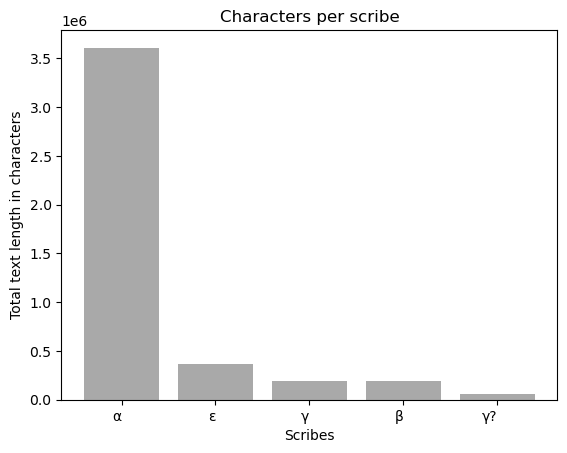

In [14]:
# [TABLE 2]

# Creating a bar plot with the total amount of characters produced by each scribe without grapheme

# Calculating the amount of characters by adding up the length of all texts written by each scribe
desired_scribes = ['α', 'β', 'γ', 'γ?', 'ε']
text_len = H[H['scribe'].isin(desired_scribes)]
text_len['len'] = text_len['text'].apply(len)
scribe_text_len = dict(text_len.groupby('scribe')['len'].sum().sort_values(ascending=False))
print(scribe_text_len)

# Creating the bar plot
plt.bar(scribe_text_len.keys(), scribe_text_len.values(), color='darkgray')

# Adding labels
plt.xlabel('Scribes')
plt.ylabel('Total text length in characters')
plt.title('Characters per scribe')

# Increasing readability
plt.xticks(ha='right', fontsize=10)

plt.show()

{'α': 3608346, 'ε': 365837, 'γ': 194806, 'β': 194722, 'γ?': 58869}


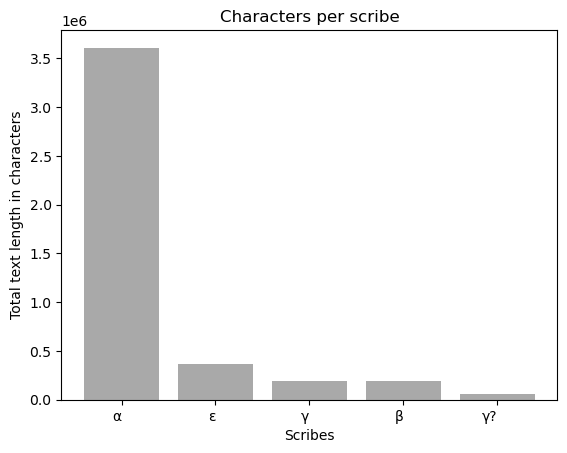

In [15]:
# [TABLE 2]

# Creating a bar plot with the total amount of characters produced by each scribe with grapheme

# Calculating the amount of characters by adding up the length of all texts written by each scribe
desired_scribes = ['α', 'β', 'γ', 'γ?', 'ε']
text_len = H[H['scribe'].isin(desired_scribes)]
combined_text = text_len.groupby('scribe')['text'].sum()

def count_graphemes(text):
    return len(list(grapheme.graphemes(text)))

# Apply the function
combined_text = combined_text.apply(count_graphemes)
combined_text = combined_text.sort_values(ascending=False)
print(dict(combined_text))

# Creating the bar plot
plt.bar(scribe_text_len.keys(), scribe_text_len.values(), color='darkgray')

# Adding labels
plt.xlabel('Scribes')
plt.ylabel('Total text length in characters')
plt.title('Characters per scribe')

# Increasing readability
plt.xticks(ha='right', fontsize=10)

plt.show()

{'α': 135, 'β': 84, 'γ': 75, 'γ?': 69, 'ε': 82}


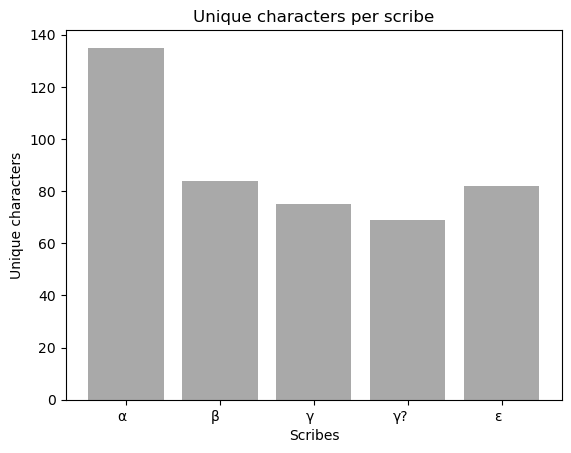

In [16]:
# [TABLE 2]

# Creating a bar plot with the total amount of unique characters per scribe based on grapheme library

# Count unique graphemes
def unique_graphemes_count(text):
    return len(set(grapheme.graphemes(text)))

# Select scribes
desired_scribes = ['α', 'β', 'γ', 'γ?', 'ε']
filtered_df = H[H['scribe'].isin(desired_scribes)]
combined_text = filtered_df.groupby('scribe')['text'].sum()

# Calculate
scribe_unique_chars = dict(combined_text.apply(unique_graphemes_count))
print(scribe_unique_chars)

# Creating the bar plot
plt.bar(scribe_unique_chars.keys(), scribe_unique_chars.values(), color='darkgray')

# Adding labels
plt.xlabel('Scribes')
plt.ylabel('Unique characters')
plt.title('Unique characters per scribe')

# Increasing readability
plt.xticks(ha='right', fontsize=10)

plt.show()

{'β': 0.24166530255906585, 'γ?': 0.23199929322378302, 'γ': 0.2212451536775861, 'α': 0.21639247567615694, 'ε': 0.12776502212017696}


/var/folders/qv/jgq1ttws58g43xdmt2gthgth0000gn/T/ipykernel_16023/1931425123.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  text_len['tokens'] = text_len['text'].apply(lambda x: len(x.split()))  # Assuming words are separated by spaces
/var/folders/qv/jgq1ttws58g43xdmt2gthgth0000gn/T/ipykernel_16023/1931425123.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  text_len['unique_tokens'] = text_len['text'].apply(lambda x: len(set(x.split())))


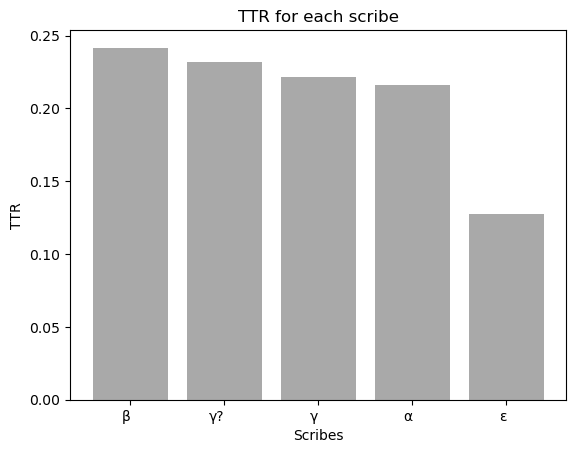

In [17]:
# [TABLE 2]

# Calculating the TTR
desired_scribes = ['α', 'β', 'γ', 'γ?', 'ε']
text_len = H[H['scribe'].isin(desired_scribes)]

# Calculate amount of words
text_len['tokens'] = text_len['text'].apply(lambda x: len(x.split()))  # Assuming words are separated by spaces

# Calculate amount of unique words
text_len['unique_tokens'] = text_len['text'].apply(lambda x: len(set(x.split())))

# Divide
scribe_ttr = (text_len.groupby('scribe')['unique_tokens'].sum() / text_len.groupby('scribe')['tokens'].sum()).sort_values(ascending=False)
scribe_ttr = dict(scribe_ttr)
print(scribe_ttr)

# Creating the bar plot
plt.bar(scribe_ttr.keys(), scribe_ttr.values(), color='darkgray')

# Adding labels
plt.xlabel('Scribes')
plt.ylabel('TTR')
plt.title('TTR for each scribe')

# Increasing readability
plt.xticks(ha='right', fontsize=10)

plt.show()

In [18]:
# [TABLE 1]

# Calculate word count for every codex
counts = H
counts['word_count'] = counts['text'].apply(lambda x: len(str(x).split()))

# Group by codex and sum the word counts for each group
total_words_by_signature = counts.groupby('signature')['word_count'].sum().reset_index()

# Display the result
print(total_words_by_signature)

                               signature  word_count
0                 Brussels KBR 1805-1808       89293
1                      Brussels KBR 2485       25033
2                   Brussels KBR 2849-51      139152
3                   Brussels KBR 2877-78       84890
4                   Brussels KBR 2879-80       77287
5                   Brussels KBR 2905-09       44847
6                      Brussels KBR 2979       78860
7                      Brussels KBR 3091       71428
8                   Brussels KBR 3093-95       35703
9                    Brussels KBR 394-98       23818
10                         Ghent UB 1374       65115
11                          Ghent UB 941       85645
12       Paris Bibliothèque Mazarine 920       51273
13  Paris Bibliothèque de l'Arsenal 8224       69426
14            Saint Petersburg BAN O 256       68812
15                     Vienna ÖNB 12.857       82513
16                     Vienna ÖNB 12.905       66658
17                     Vienna ÖNB 13.708      

/var/folders/qv/jgq1ttws58g43xdmt2gthgth0000gn/T/ipykernel_16023/2644001387.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  counts['word_count'] = counts['text'].apply(lambda x: len(str(x).split()))


In [19]:
# [TABLE 1]

# Calculate unique words for every codex
concatenated_text_by_signature = H.groupby('signature')['text'].apply(lambda x: ' '.join(x)).reset_index()

# Calculate the total number of unique words for each group
concatenated_text_by_signature['unique_words'] = concatenated_text_by_signature['text'].apply(lambda x: len(set(str(x).split())))

# Display the result
print(concatenated_text_by_signature[['signature', 'unique_words']])

                               signature  unique_words
0                 Brussels KBR 1805-1808         14033
1                      Brussels KBR 2485          4299
2                   Brussels KBR 2849-51         18817
3                   Brussels KBR 2877-78         12161
4                   Brussels KBR 2879-80         10982
5                   Brussels KBR 2905-09          8567
6                      Brussels KBR 2979         14261
7                      Brussels KBR 3091          9126
8                   Brussels KBR 3093-95          7608
9                    Brussels KBR 394-98          4897
10                         Ghent UB 1374         11362
11                          Ghent UB 941         12546
12       Paris Bibliothèque Mazarine 920         10208
13  Paris Bibliothèque de l'Arsenal 8224         17423
14            Saint Petersburg BAN O 256         21124
15                     Vienna ÖNB 12.857         11445
16                     Vienna ÖNB 12.905         12219
17        

## Abbreviation densities

In [20]:
# We split up the texts into segments of 5000 characters

#segment_size = 5000
#segments = []

#for _, row in H.iterrows():
#    starting_index, ending_index = 0, segment_size
#    text = row['text']
#    while ending_index < len(text):
#        segments.append((text[starting_index:ending_index], row['num_date'], row['scribe'], row['signature'], row['id'], row['translator'], row['content']))
#        starting_index += segment_size
#        ending_index += segment_size

#segments = pd.DataFrame(segments, columns=['text', 'date', 'scribe', 'signature', 'id', 'translator', 'content'])
#segments.sample(5)

In [21]:
#################### OF ####################

In [22]:
segment_size = 5000
segments = []

for _, row in H.iterrows():
    text = row['text']
    graphemes = list(grapheme.graphemes(text))
    
    starting_index, ending_index = 0, segment_size
    while ending_index < len(graphemes):
        segment_graphemes = graphemes[starting_index:ending_index]
        segment_text = ''.join(segment_graphemes)
        
        segments.append((segment_text, row['num_date'], row['scribe'], row['signature'], row['id'], row['translator'], row['content']))
        
        starting_index += segment_size
        ending_index += segment_size

segments = pd.DataFrame(segments, columns=['text', 'date', 'scribe', 'signature', 'id', 'translator', 'content'])
segments.sample(5)

,text,date,scribe,signature,id,translator,content
264,ade j sin scade want die hē mijns scamꝫ e mur...,1350.0,Brussels KBR 2979-A,Brussels KBR 2979,Brussels KBR 2979-IV-A,NaN,evangLuc
125,onc ghe boudē op wele nee gegʼ mēschē e sat e...,1337.5,Saint Petersburg BAN O 256-G,Saint Petersburg BAN O 256,Saint Petersburg BAN O 256-III-G,NaN,evangMarc
218,ziekē Te rechte was dat wiis salich die dese ...,1350.0,Paris Bibliothèque de l'Arsenal 8224-C,Paris Bibliothèque de l'Arsenal 8224,Paris Bibliothèque de l'Arsenal 8224-II-C,NaN,horlogium
360,er vore dat aēsichte des vadʼs hier op sal aar...,1362.5,ε,Brussels KBR 3091,Brussels KBR 3091-I-ε,NaN,tabernRuusbr
268,j selē wʼdē gheschedē Jegen die iij De uadʼ i...,1350.0,Brussels KBR 2979-A,Brussels KBR 2979,Brussels KBR 2979-IV-A,NaN,evangLuc


{'α': 706, 'ε': 73, 'γ': 37, 'β': 36, 'γ?': 11}


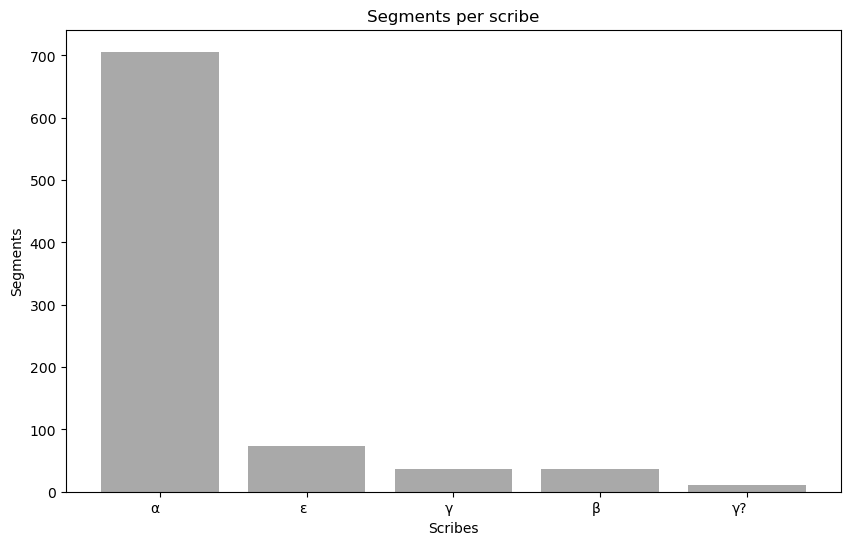

In [23]:
# [TABLE 2]

# Bar plot with segments per scribe
desired_scribes = ['α', 'β', 'γ', 'γ?', 'ε']
segments_per_scribe = segments[segments['scribe'].isin(desired_scribes)]
segments_per_scribe = dict(segments_per_scribe['scribe'].value_counts())
print(segments_per_scribe)

# Creating bar plot
plt.figure(figsize=(10, 6))
plt.bar(segments_per_scribe.keys(), segments_per_scribe.values(), color='darkgray')

# Adding labels
plt.xlabel('Scribes')
plt.ylabel('Segments')
plt.title('Segments per scribe')

# Increasing readability
plt.xticks(ha='right', fontsize=10)

plt.show()

### Dataframe bringing together all the information

In [24]:
# create df

# extract the relevant statistics
num_codices = H.groupby('scribe')['signature'].nunique()
num_prod_units = H.groupby('scribe')['pu'].nunique()
total_chars_no_grapheme = H.groupby('scribe')['text'].apply(lambda x: ''.join(x)).str.len()
total_chars_with_grapheme = H.groupby('scribe')['text'].apply(lambda x: ''.join(x)).apply(lambda x: len(list(grapheme.graphemes(x))))
segments_per_scribe = segments.groupby('scribe').size()
unique_chars_per_scribe = H.groupby('scribe')['text'].apply(lambda x: len(set(''.join(x))))

# calculating TTR for each scribe
H['tokens'] = H['text'].apply(lambda x: len(x.split()))
H['unique_tokens'] = H['text'].apply(lambda x: len(set(x.split())))
ttr_per_scribe = H.groupby('scribe')['unique_tokens'].sum() / H.groupby('scribe')['tokens'].sum()

# summary
summary_df = pd.DataFrame({
    'Scribe': desired_scribes,
    'Present in different codices': [num_codices.get(scribe, 0) for scribe in desired_scribes],
    'Production units': [num_prod_units.get(scribe, 0) for scribe in desired_scribes],
    'Characters (no grapheme)': [total_chars_no_grapheme.get(scribe, 0) for scribe in desired_scribes],
    'Characters (grapheme)': [total_chars_with_grapheme.get(scribe, 0) for scribe in desired_scribes],
    'Segments': [segments_per_scribe.get(scribe, 0) for scribe in desired_scribes],
    'Unique characters': [unique_chars_per_scribe.get(scribe, 0) for scribe in desired_scribes],
    'TTR': [round(ttr_per_scribe.get(scribe, 0), 2) for scribe in desired_scribes]
})

summary_df

/var/folders/qv/jgq1ttws58g43xdmt2gthgth0000gn/T/ipykernel_16023/1563214447.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  H['tokens'] = H['text'].apply(lambda x: len(x.split()))
/var/folders/qv/jgq1ttws58g43xdmt2gthgth0000gn/T/ipykernel_16023/1563214447.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  H['unique_tokens'] = H['text'].apply(lambda x: len(set(x.split())))


,Scribe,Present in different codices,Production units,Characters (no grapheme),Characters (grapheme),Segments,Unique characters,TTR
0,α,9,32,3609770,3608346,706,107,0.22
1,β,3,4,194756,194722,36,80,0.24
2,γ,1,3,194809,194806,37,73,0.22
3,γ?,1,1,58871,58869,11,69,0.23
4,ε,1,1,365975,365837,73,75,0.13


In [25]:
# convert to LaTeX table
latex_table = summary_df.to_latex(index=False, header=True, caption="Summary of Scribe Statistics", label="tab:scribe_summary", longtable=False)
print(latex_table)

\begin{table}
\caption{Summary of Scribe Statistics}
\label{tab:scribe_summary}
\begin{tabular}{lrrrrrrr}
\toprule
Scribe & Present in different codices & Production units & Characters (no grapheme) & Characters (grapheme) & Segments & Unique characters & TTR \\
\midrule
α & 9 & 32 & 3609770 & 3608346 & 706 & 107 & 0.220000 \\
β & 3 & 4 & 194756 & 194722 & 36 & 80 & 0.240000 \\
γ & 1 & 3 & 194809 & 194806 & 37 & 73 & 0.220000 \\
γ? & 1 & 1 & 58871 & 58869 & 11 & 69 & 0.230000 \\
ε & 1 & 1 & 365975 & 365837 & 73 & 75 & 0.130000 \\
\bottomrule
\end{tabular}
\end{table}



We calculate two types of abbreviation density:

- character abbreviation density: brevigraphs divided by *all* 'normal' letters;
- word abbreviation density: abbreviated words divided by full-length words.

In [26]:
def abbr_density_character(text):
    
    cnts = Counter(unicodedata.normalize('NFC', text))
    alph = np.sum([cnts[c] for c in set(letters)]) # count all letters
    brev = np.sum([cnts[c] for c in set(brevigraphs)]) # count all brevigraphs
    return brev / alph # brevigraphs divided by letters

densities_character = [abbr_density_character(t) for t in segments['text']]
segments['abbr_char'] = densities_character # abbreviation density per segment

In [27]:
def abbr_density_word(text, counter):
    
    # A regular expression to find words, including Latin extensions such as macrons (ā, ē, ī, ō, ū)
    # and other specific characters (ʓ, ʒ, ̄, Ẕ, Ṕ, ṕ, ū̄, ē̄, ā̄, ī̄, ō̄, ȳ, ġ, Ā, Ǡ, ǡ, ǣ, Ǣ, ̄̄, ̄̆, ̄̍)
    # If we did not make this explicit, some characters would be interpreted as punctuation
    words = re.findall(r'\b(?:[\w\u0101\u0100\u0113\u0112\u012b\u012A\u014D\u014C\u016B\u016A\u0233\u0232\u0304\uE554\uE154\uE5B8\uE5DC\uE665\uE681]+)(?=\b|$)', text.lower())
    
    num_abbr_words = 0
    num_total_words = 0
    abbr_words = []

    for word in words:
        if '\u016A' in word:
            print(f"Word containing '\\u016A': {word}")

    for word in words:
        cnts = Counter(unicodedata.normalize('NFD', word))
        alph = np.sum([cnts[c] for c in set(letters)])
        brev = np.sum([counter[c] for c in cnts if c in counter])

        if brev > 0:
            num_abbr_words += 1
            abbr_words.append(word)

        num_total_words += 1

    density = num_abbr_words / num_total_words
    return density, abbr_words

densities_word = []
abbreviated_words = []

for t in segments['text']:
    density, abbr_words = abbr_density_word(t, brevigraphs)
    densities_word.append(density)
    abbreviated_words.extend(abbr_words)

segments['abbr_word'] = densities_word

In [28]:
segments

,text,date,scribe,signature,id,translator,content,abbr_char,abbr_word
0,es and net aeroeg ē en wna M Sadoch ghebaer ac...,1337.5,Saint Petersburg BAN O 256-G,Saint Petersburg BAN O 256,Saint Petersburg BAN O 256-II-G,NaN,evangMath,0.118820,0.337461
1,oemēdʼ erscap Daerōme doet wʼdeghe vᵒcht dʼ p...,1337.5,Saint Petersburg BAN O 256-G,Saint Petersburg BAN O 256,Saint Petersburg BAN O 256-II-G,NaN,evangMath,0.127532,0.341262
2,ene mate maer op enen caudelare opt dat se l...,1337.5,Saint Petersburg BAN O 256-G,Saint Petersburg BAN O 256,Saint Petersburg BAN O 256-II-G,NaN,evangMath,0.110577,0.310982
3,e toecome dijn rike di wille gheschie alsoe...,1337.5,Saint Petersburg BAN O 256-G,Saint Petersburg BAN O 256,Saint Petersburg BAN O 256-II-G,NaN,evangMath,0.115483,0.315737
4,e wᵃchte s reckēde segghēde Jc wille wʼdꝫ suuʼ...,1337.5,Saint Petersburg BAN O 256-G,Saint Petersburg BAN O 256,Saint Petersburg BAN O 256-II-G,NaN,evangMath,0.139090,0.340954
...,...,...,...,...,...,...,...,...,...
1488,ōtfermēchede Es ontᵒest e vʼranesse mede Ser...,1402.0,α,Vienna ÖNB 13.708,Vienna ÖNB 13.708-IV-α,NaN,sph2-2,0.083912,0.287257
1489,ᵃ Van den keyser aureliꝰ ꝯmodꝰ lvi Dine tebere...,1402.0,α,Vienna ÖNB 13.708,Vienna ÖNB 13.708-IV-α,NaN,sph2-2,0.084031,0.254323
1490,ē waʼ sagers waer si ware Mettē godē seidē si ...,1402.0,α,Vienna ÖNB 13.708,Vienna ÖNB 13.708-IV-α,NaN,sph2-2,0.096044,0.296715
1491,Januamius Noumaēt xxxi dage demane xxx Maersda...,1425.0,Brussels KBR 2905-09-unknown,Brussels KBR 2905-09,Brussels KBR 2905-09-I-unknown,NaN,kalender,0.049344,0.171459


Calculating the character abbreviation density for all of the scribes:

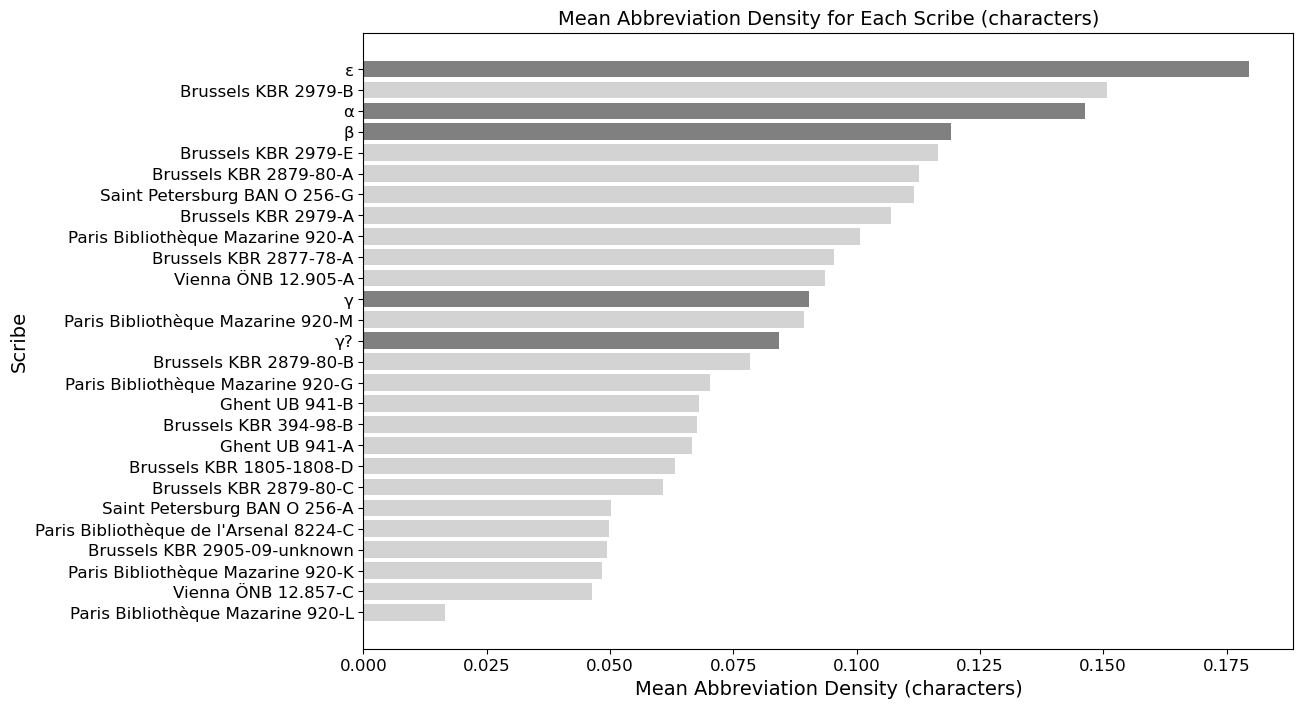

In [29]:
# Calculate mean character abbreviation rate for each scribe
desired_scribes = ['α', 'β', 'γ', 'γ?', 'ε' ]
mean_abbr_rate = segments.groupby('scribe')['abbr_char'].mean().reset_index()

# Sort the DataFrame by 'abbr' in descending order
mean_abbr_rate = mean_abbr_rate.sort_values(by='abbr_char', ascending=False)

# Create the figure and axis
fig, ax = plt.subplots(figsize=(12, 8))

# Create a horizontal bar chart
bars = plt.barh(mean_abbr_rate['scribe'], mean_abbr_rate['abbr_char'], color=['grey' if scribe in desired_scribes else 'lightgrey' for scribe in mean_abbr_rate['scribe']])

# Set the title and labels
plt.title('Mean Abbreviation Density for Each Scribe (characters)', fontsize=14)
plt.xlabel('Mean Abbreviation Density (characters)', fontsize=14)
plt.ylabel('Scribe', fontsize=14)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Invert the y-axis to have the highest value at the top
ax.invert_yaxis()

# Show the plot
plt.show()

Calculating the word abbreviation density for all of the scribes:

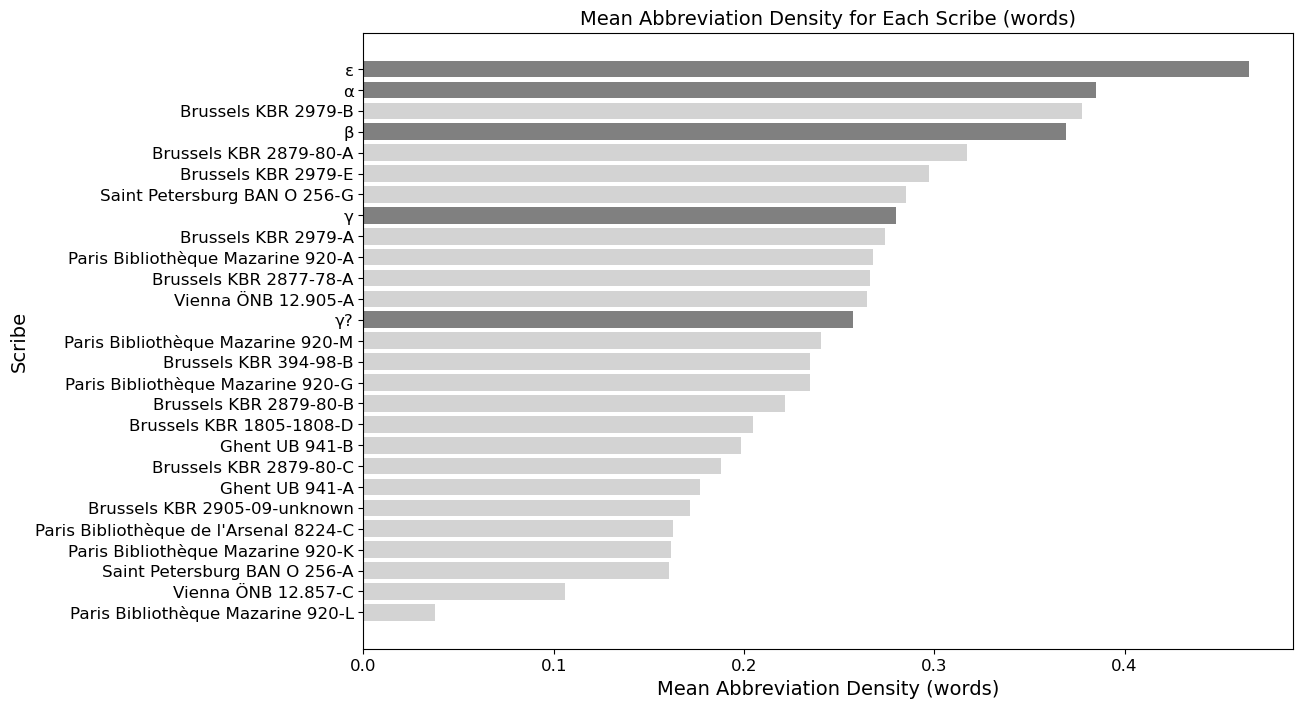

In [30]:
# Calculate mean word abbreviation rate for each scribe
mean_abbr_rate = segments.groupby('scribe')['abbr_word'].mean().reset_index()

# Sort the DataFrame by 'abbr' in descending order
mean_abbr_rate = mean_abbr_rate.sort_values(by='abbr_word', ascending=False)

# Create the figure and axis
fig, ax = plt.subplots(figsize=(12, 8))

# Create a horizontal bar chart
bars = plt.barh(mean_abbr_rate['scribe'], mean_abbr_rate['abbr_word'], color=['grey' if scribe in desired_scribes else 'lightgrey' for scribe in mean_abbr_rate['scribe']])

# Set the title and labels
plt.title('Mean Abbreviation Density for Each Scribe (words)', fontsize=14)
plt.xlabel('Mean Abbreviation Density (words)', fontsize=14)
plt.ylabel('Scribe', fontsize=14)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Invert the y-axis to have the highest value at the top
ax.invert_yaxis()

# Show the plot
plt.show()

Creating a combined plot:

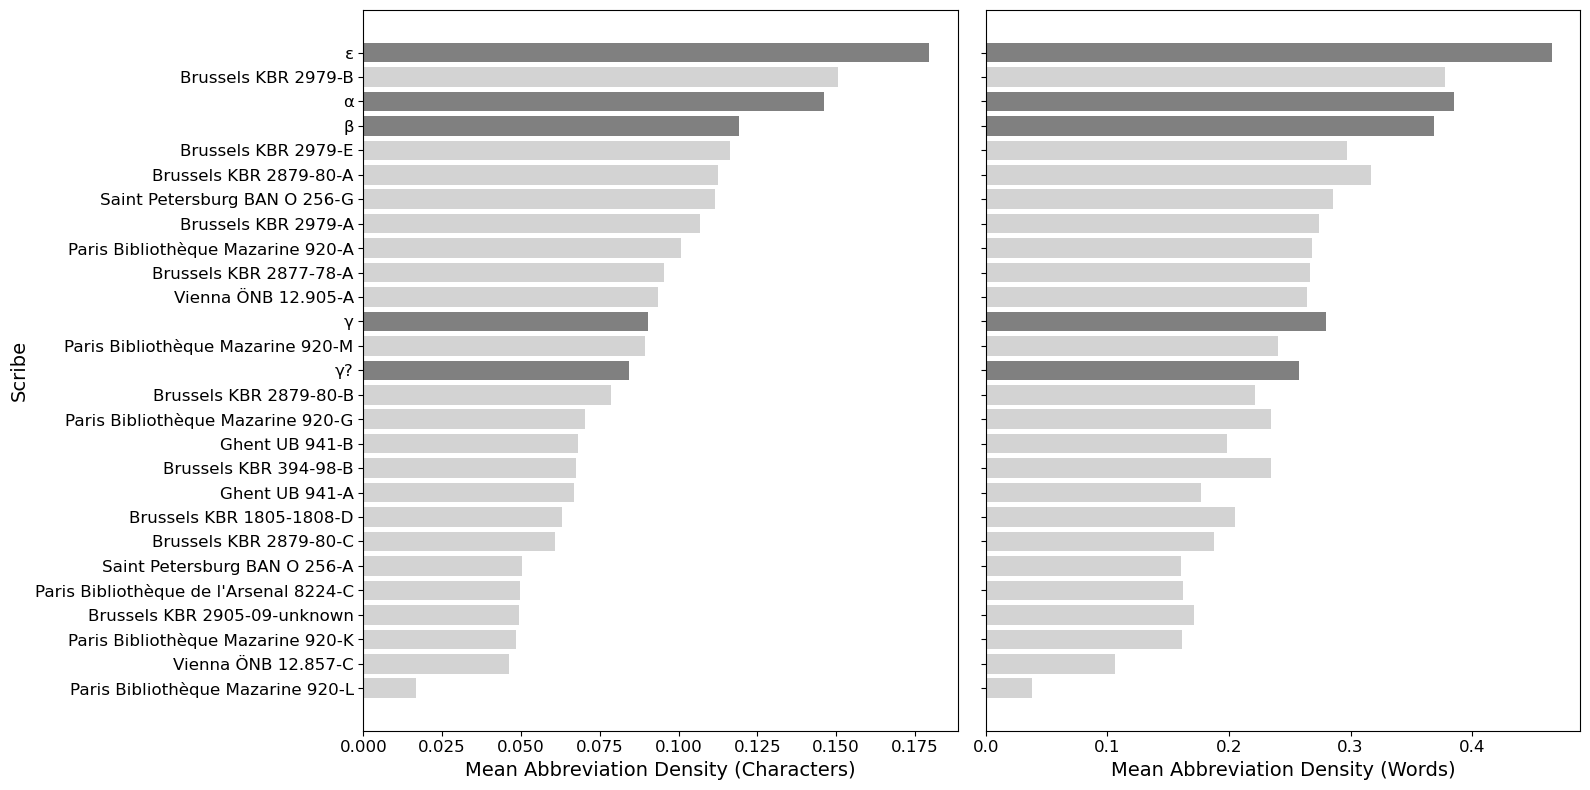

In [31]:
desired_scribes = ['α', 'β', 'γ', 'γ?', 'ε']
mean_abbr_char = segments.groupby('scribe')['abbr_char'].mean().reset_index()
mean_abbr_char = mean_abbr_char.sort_values(by='abbr_char', ascending=False)

#  mean word abbreviation rate for each scribe
mean_abbr_word = segments.groupby('scribe')['abbr_word'].mean().reset_index()
mean_abbr_word = mean_abbr_word.sort_values(by='abbr_word', ascending=False)

# fig with subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8), sharey=True)

# character-level data
ax1.barh(mean_abbr_char['scribe'], mean_abbr_char['abbr_char'], 
         color=['grey' if scribe in desired_scribes else 'lightgrey' for scribe in mean_abbr_char['scribe']])
ax1.set_xlabel('Mean Abbreviation Density (Characters)', fontsize=14)
ax1.set_ylabel('Scribe', fontsize=14)
ax1.invert_yaxis()

# word-level data
ax2.barh(mean_abbr_word['scribe'], mean_abbr_word['abbr_word'], 
         color=['grey' if scribe in desired_scribes else 'lightgrey' for scribe in mean_abbr_word['scribe']])
ax2.set_xlabel('Mean Abbreviation Density (Words)', fontsize=14)

ax1.tick_params(axis='both', which='major', labelsize=12)
ax2.tick_params(axis='both', which='major', labelsize=12)

plt.tight_layout()
plt.grid(False)
# only the most important figures and the figures used in the book chapter are saved
plt.savefig('figures-and-tables/figure_1.png', dpi=1200)
plt.show()

Observations:
- The known Herne scribes seem to use abbreviations regularly.

Accordingly, we will zoom in on them individually
    

#### α individually:

In [32]:
# Filter the segments DataFrame for scribe α
scribe_alpha_segments = segments[segments['scribe'] == 'α']

# Calculate the average abbreviation density
average_density_scribe_alpha_word = scribe_alpha_segments['abbr_word'].mean()
print(f'word abbreviation density: {average_density_scribe_alpha_word}')

average_density_scribe_alpha = scribe_alpha_segments['abbr_char'].mean()
print(f'character abbreviation density: {average_density_scribe_alpha}')

word abbreviation density: 0.38524644325830293
character abbreviation density: 0.14628649474439276


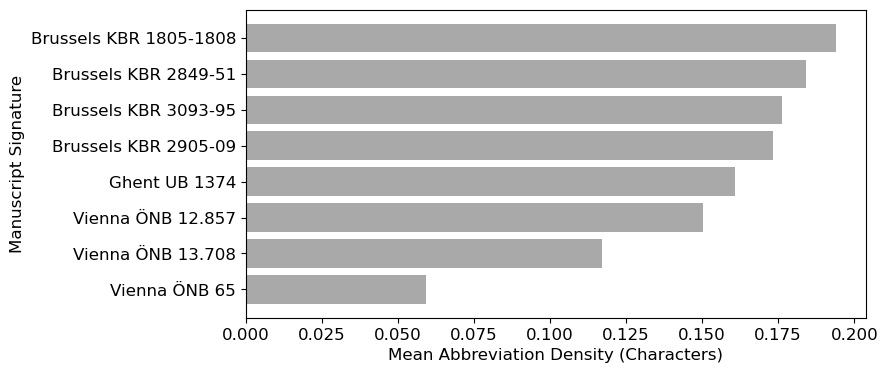

In [33]:
# Filter data and calculate the mean abbreviation frequency
filtered_data = segments[segments['scribe'] == 'α'].groupby('signature')['abbr_char'].mean().reset_index()

# Sort the DataFrame by 'abbr' in descending order
filtered_data = filtered_data.sort_values(by='abbr_char', ascending=False)

# Create the figure and axis
fig, ax = plt.subplots(figsize=(8, 4))

# Create a horizontal bar chart
bars = plt.barh(filtered_data['signature'], filtered_data['abbr_char'], color='darkgrey')

# Set the title and labels
#plt.title('Mean abbreviation density (Characters) for Scribe α by manuscript signature', fontsize=14)
plt.xlabel('Mean Abbreviation Density (Characters)', fontsize=12)
plt.ylabel('Manuscript Signature', fontsize=12)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Invert the y-axis to have the highest value at the top
ax.invert_yaxis()
plt.grid(False)
plt.savefig('figures-and-tables/figure_2.png', dpi=1200, bbox_inches='tight')
# Show the plot
plt.show()

Observations:
- Vienna, ÖNB, SN 65; Vienna, ÖNB, Cod. 13.708; and Vienna, ÖNB, 12.857 seem to differ in terms of abbreviation density.

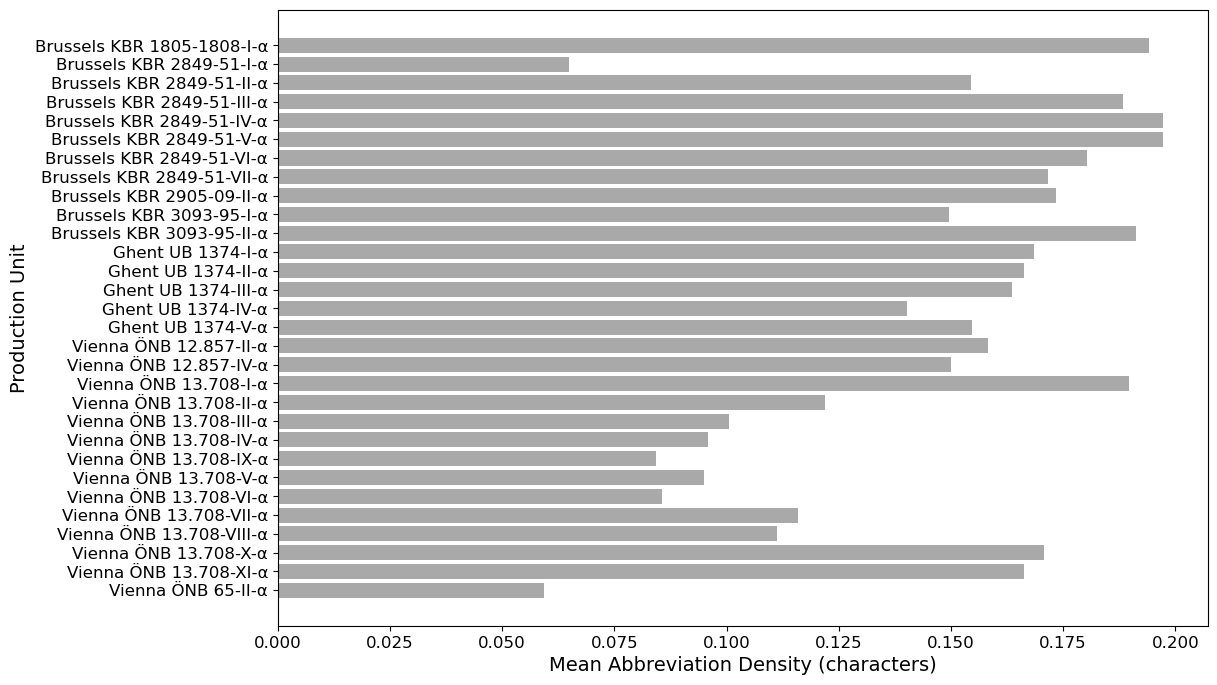

In [34]:
# Filter data and calculate the mean abbreviation frequency
filtered_data = segments[segments['scribe'] == 'α'].groupby('id')['abbr_char'].mean().reset_index()

# Sample y-labels and corresponding colors
y_labels = filtered_data['id'].unique()
color_map = {'Wenen, ÖNB, 13.708-II-α': 'silver',
             'Wenen, ÖNB, 13.708-X-α': 'silver',
             'Wenen, ÖNB, 13.708-XI-α': 'silver',
             'Wenen, ÖNB, 13.708-I-α': 'grey',
             'Wenen, ÖNB, 13.708-III-α': 'grey',
             'Wenen, ÖNB, 13.708-IV-α': 'grey',
             'Wenen, ÖNB, 13.708-V-α': 'grey',
             'Wenen, ÖNB, 13.708-VI-α': 'grey',
             'Wenen, ÖNB, 13.708-VII-α': 'grey',
             'Wenen, ÖNB, 13.708-VIII-α': 'grey',
             'Wenen, ÖNB, 13.708-I-α': 'grey',
             'Wenen, ÖNB, 13.708-IX-α': 'grey',
             'Wenen, ÖNB, 65-II-α': 'black'
            }


# Create the figure and axis
fig, ax = plt.subplots(figsize=(12, 8))

# Create a horizontal bar chart with manually specified colors
bars = plt.barh(filtered_data['id'], filtered_data['abbr_char'], color='darkgrey')

# Set the title and labels
#plt.title('Mean Abbreviation Density (characters) for Scribe α per production unit', fontsize=14)
plt.xlabel('Mean Abbreviation Density (characters)', fontsize=14)
plt.ylabel('Production Unit', fontsize=14)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Invert the y-axis to have the highest value at the top
ax.invert_yaxis()
plt.savefig('figures-and-tables/figure_3.svg', format='svg', dpi=1200)
# Show the plot
plt.show()


Observations:

* old core: II, X, XI: higher abbreviation density (1393-1394);
* new core: I, III, IV, V, VI, VII, VIII, IX: lower abbreviation density (1402);
* production unit I strange abbreviation density because it was part of the old core or because α translated it himself?;
* Vienna, ÖNB, SN 65: very low density.

Let's have a closer look at Vienna, ÖNB, SN 65

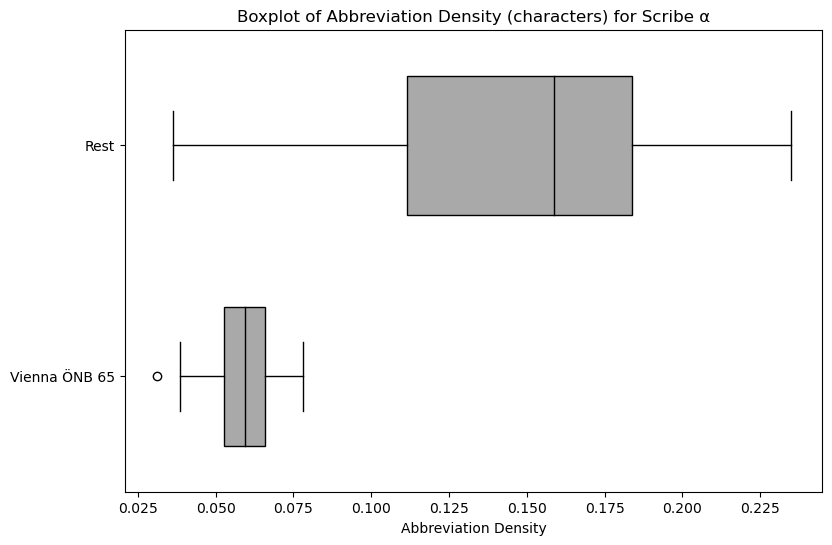

In [35]:
# Add the 'class' column to the segments DataFrame
classes = ['Vienna ÖNB 65' if sig == 'Vienna ÖNB 65' else 'Rest' for sig in segments['signature']]
segments['class'] = classes

# Filter the data for Scribe α
filtered_data = segments[segments['scribe'] == 'α']

# Group the data by 'class' for the boxplot
grouped_data = [filtered_data[filtered_data['class'] == cls]['abbr_char'] for cls in ['Vienna ÖNB 65', 'Rest']]

# Create the figure and axis
fig, ax = plt.subplots(figsize=(9, 6))

# Create a box plot
box = plt.boxplot(grouped_data, labels=['Vienna ÖNB 65', 'Rest'], vert=False, widths=0.6, patch_artist=True, medianprops={'color': 'black'})

# Set the title and labels
plt.title('Boxplot of Abbreviation Density (characters) for Scribe α', fontsize=12)
plt.xlabel('Abbreviation Density', fontsize=10)
plt.yticks([1, 2], ['Vienna ÖNB 65', 'Rest'], fontsize=10)

# Customize the boxplot colors
colors = ['darkgray', 'darkgray']
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)

# Show the plot
plt.show()


Let's have a closer look at Vienna, ÖNB, 12.857

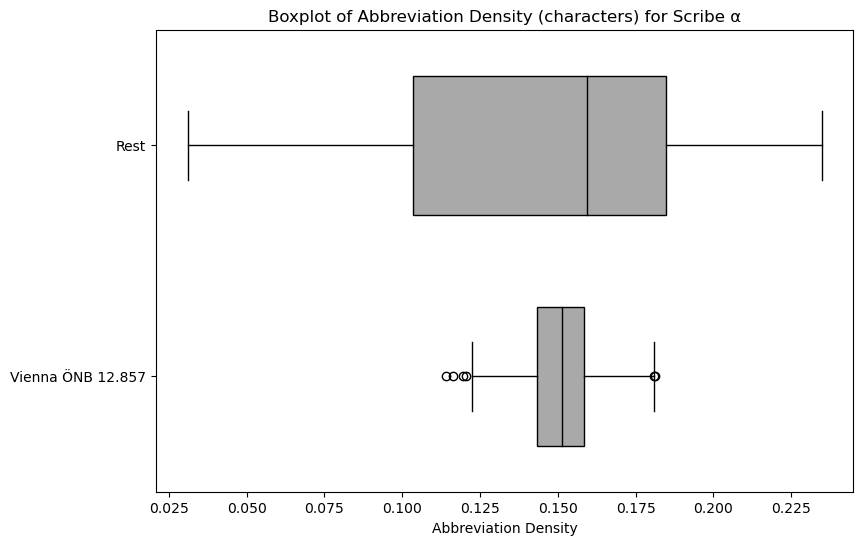

In [36]:
# Add the 'class' column to the segments DataFrame
classes = ['Vienna ÖNB 12.857' if sig == 'Vienna ÖNB 12.857' else 'Rest' for sig in segments['signature']]
segments['class'] = classes

# Filter the data for Scribe α
filtered_data = segments[segments['scribe'] == 'α']

# Group the data by 'class' for the boxplot
grouped_data = [filtered_data[filtered_data['class'] == cls]['abbr_char'] for cls in ['Vienna ÖNB 12.857', 'Rest']]

# Create the figure and axis
fig, ax = plt.subplots(figsize=(9, 6))

# Create a box plot
box = plt.boxplot(grouped_data, labels=['Vienna ÖNB 12.857', 'Rest'], vert=False, widths=0.6, patch_artist=True, medianprops={'color': 'black'})

# Set the title and labels
plt.title('Boxplot of Abbreviation Density (characters) for Scribe α', fontsize=12)
plt.xlabel('Abbreviation Density', fontsize=10)
plt.yticks([1, 2], ['Vienna ÖNB 12.857', 'Rest'], fontsize=10)

# Customize the boxplot colors
colors = ['darkgray', 'darkgray']
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)

# Show the plot
plt.show()


Let's have a closer look at Vienna, ÖNB, Cod. 13.708

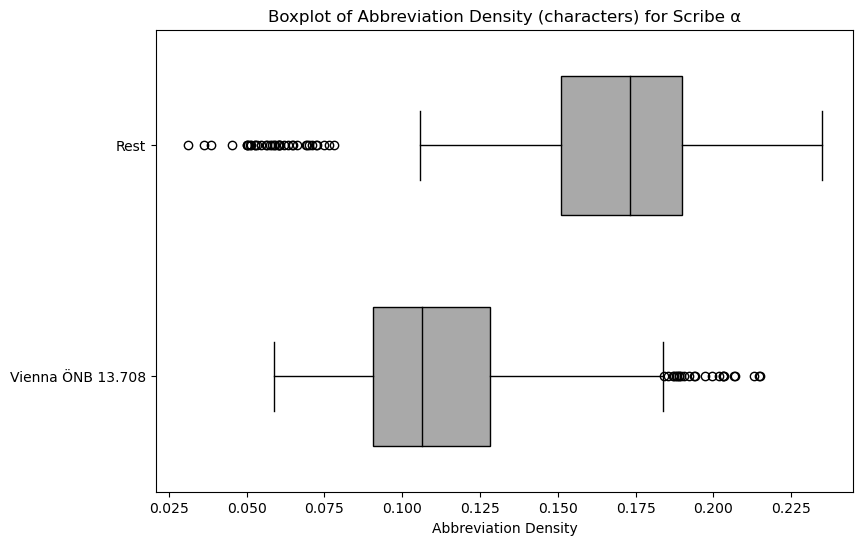

In [37]:
# Add the 'class' column to the segments DataFrame
classes = ['Vienna ÖNB 13.708' if sig == 'Vienna ÖNB 13.708' else 'Rest' for sig in segments['signature']]
segments['class'] = classes

# Filter the data for Scribe α
filtered_data = segments[segments['scribe'] == 'α']

# Group the data by 'class' for the boxplot
grouped_data = [filtered_data[filtered_data['class'] == cls]['abbr_char'] for cls in ['Vienna ÖNB 13.708', 'Rest']]

# Create the figure and axis
fig, ax = plt.subplots(figsize=(9, 6))

# Create a box plot
box = plt.boxplot(grouped_data, labels=['Vienna ÖNB 13.708', 'Rest'], vert=False, widths=0.6, patch_artist=True, medianprops={'color': 'black'})

# Set the title and labels
plt.title('Boxplot of Abbreviation Density (characters) for Scribe α', fontsize=12)
plt.xlabel('Abbreviation Density', fontsize=10)
plt.yticks([1, 2], ['Vienna ÖNB 13.708', 'Rest'], fontsize=10)

# Customize the boxplot colors
colors = ['darkgray', 'darkgray']
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)

# Show the plot
plt.show()


Let's make a plot depicting all three manuscripts combined

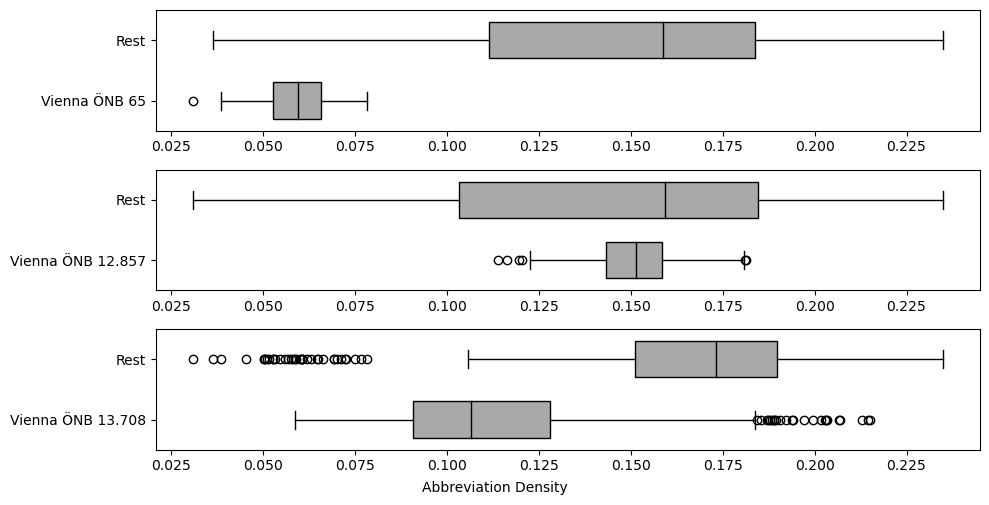

In [38]:

fig, axes = plt.subplots(3, 1, figsize=(10, 7), sharex=False)

manuscript_classes = ['Vienna ÖNB 65', 'Vienna ÖNB 12.857', 'Vienna ÖNB 13.708']
colors = ['darkgray', 'darkgray']

# iterate over manuscript classes to create boxplots
for i, manuscript_class in enumerate(manuscript_classes):
    segments['class'] = [manuscript_class if sig == manuscript_class else 'Rest' for sig in segments['signature']]
    
    # filter data for α
    filtered_data = segments[segments['scribe'] == 'α']
    
    # group the data by 'class' for the boxplot
    grouped_data = [filtered_data[filtered_data['class'] == cls]['abbr_char'] for cls in [manuscript_class, 'Rest']]
    
    bplot = axes[i].boxplot(grouped_data, labels=[manuscript_class, 'Rest'], vert=False, widths=0.6, patch_artist=True, medianprops={'color': 'black'})
    
    #axes[i].set_title(f'Boxplot of Abbreviation Density (Characters) for Scribe α in {manuscript_class}', fontsize=12)
    axes[i].set_yticklabels([manuscript_class, 'Rest'], fontsize=10)
    
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)

fig.text(0.5, 0.04, 'Abbreviation Density', ha='center', fontsize=10)


plt.tight_layout(rect=[0, 0.045, 1, 0.75])
plt.savefig('figures-and-tables/figure_4.png', dpi=1200, bbox_inches='tight')
plt.show()


#### β individually:

In [39]:
# Filter the segments DataFrame for scribe β
scribe_beta_segments = segments[segments['scribe'] == 'β']

# Calculate the average abbreviation densities
average_density_scribe_beta_word = scribe_beta_segments['abbr_word'].mean()
print(f'word abbreviation density: {average_density_scribe_beta_word}')

average_density_scribe_beta = scribe_beta_segments['abbr_char'].mean()
print(f'character abbreviation density: {average_density_scribe_beta}')

word abbreviation density: 0.36902903285635236
character abbreviation density: 0.1191788254254741


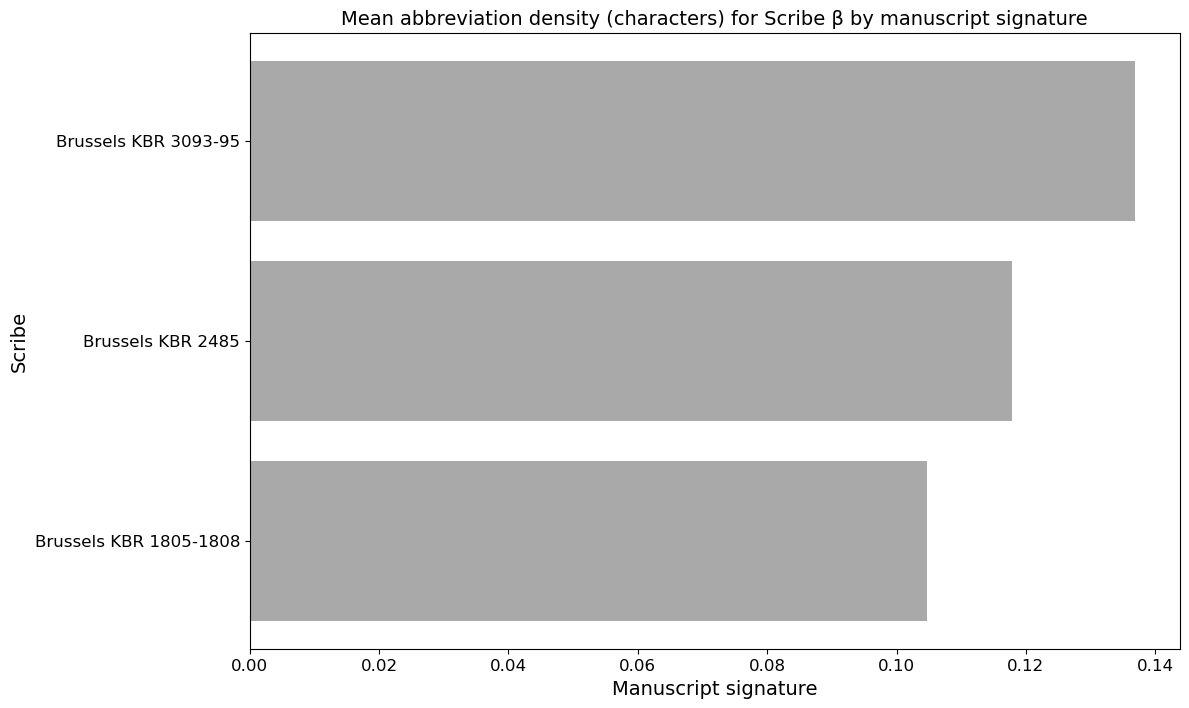

In [40]:
# Filter the data and calculate the mean abbreviation frequency
filtered_data = segments[segments['scribe'] == 'β'].groupby('signature')['abbr_char'].mean().reset_index()

# Sort the DataFrame by 'abbr' in descending order
filtered_data = filtered_data.sort_values(by='abbr_char', ascending=False)

# Create the figure and axis
fig, ax = plt.subplots(figsize=(12, 8))

# Create a horizontal bar chart
bars = plt.barh(filtered_data['signature'], filtered_data['abbr_char'], color='darkgray')

# Set the title and labels
plt.title('Mean abbreviation density (characters) for Scribe β by manuscript signature', fontsize=14)
plt.xlabel('Manuscript signature', fontsize=14)
plt.ylabel('Scribe', fontsize=14)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Invert the y-axis to have the highest value at the top
ax.invert_yaxis()

# Show the plot
plt.show()

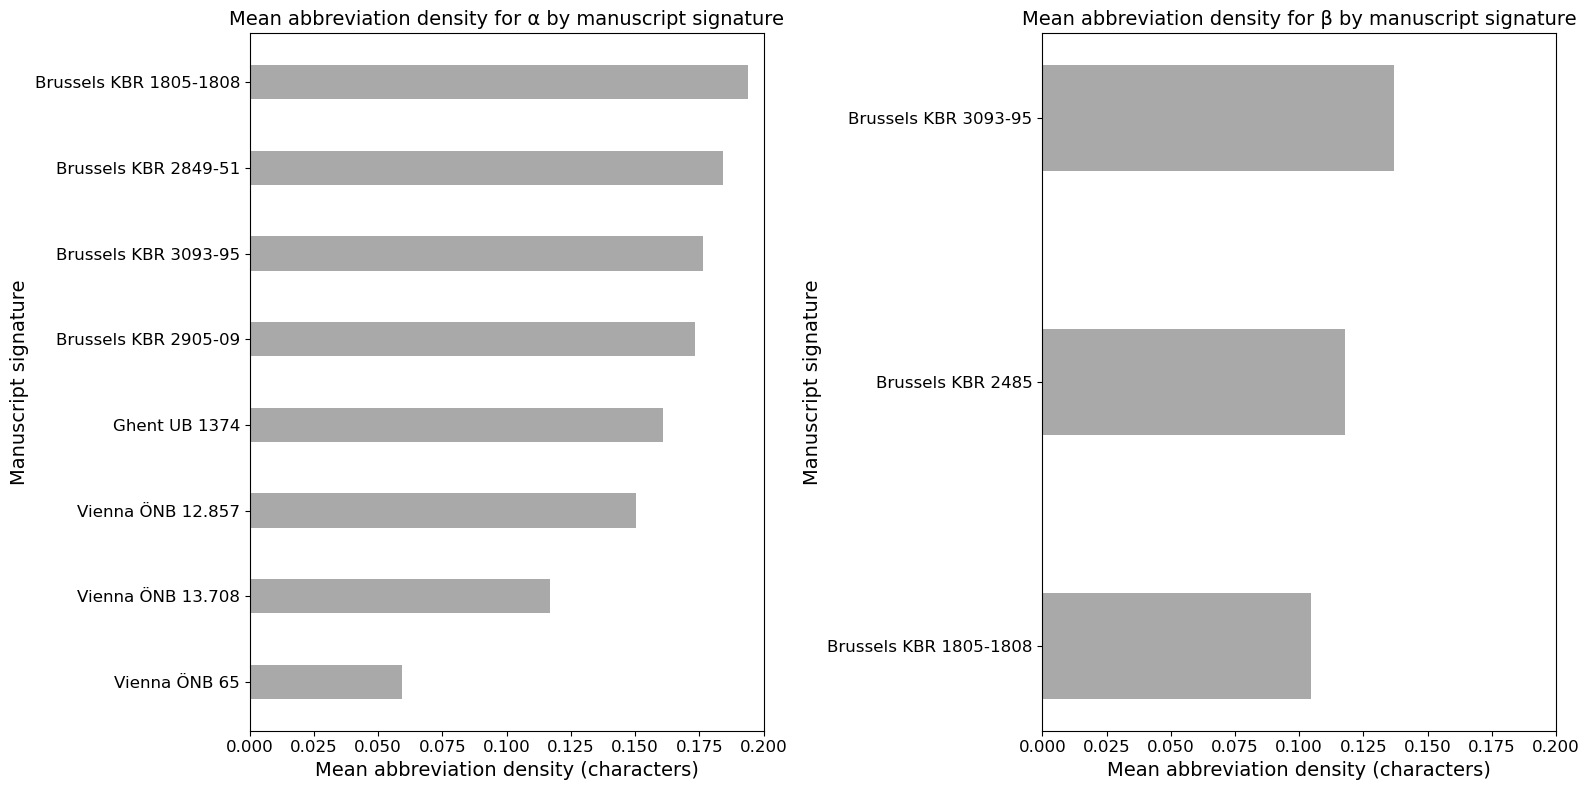

In [41]:
# Creating a plot with just α and β next to each other

# Filter data and calculate the mean abbreviation frequency for Scribe α
filtered_data_alpha = segments[segments['scribe'] == 'α'].groupby('signature')['abbr_char'].mean().reset_index()

# Sort the DataFrame by 'abbr' in descending order
filtered_data_alpha = filtered_data_alpha.sort_values(by='abbr_char', ascending=False)

# Filter data and calculate the mean abbreviation frequency for Scribe β
filtered_data_beta = segments[segments['scribe'] == 'β'].groupby('signature')['abbr_char'].mean().reset_index()

# Sort the DataFrame by 'abbr' in descending order
filtered_data_beta = filtered_data_beta.sort_values(by='abbr_char', ascending=False)

# Determine the maximum mean abbreviation density for both scribes
max_density = max(filtered_data_alpha['abbr_char'].max(), filtered_data_beta['abbr_char'].max())

# Set up the figure and axes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8), sharex=True, gridspec_kw={'width_ratios': [1, 1]})

# Plot for Scribe α
bar_width = 0.4  # Adjust this value to set the bar thickness
bars_alpha = ax1.barh(filtered_data_alpha['signature'], filtered_data_alpha['abbr_char'], color='darkgray', height=bar_width, linewidth=1.2)
ax1.set_title('Mean abbreviation density for α by manuscript signature', fontsize=14)
ax1.set_xlabel('Mean abbreviation density (characters)', fontsize=14)
ax1.set_ylabel('Manuscript signature', fontsize=14)
ax1.tick_params(axis='both', labelsize=12)
ax1.invert_yaxis()
ax1.set_xlim([0, 0.2])  # Adjusted x-axis range

# Plot for Scribe β
bars_beta = ax2.barh(filtered_data_beta['signature'], filtered_data_beta['abbr_char'], color='darkgray', height=bar_width, linewidth=1.2)
ax2.set_title('Mean abbreviation density for β by manuscript signature', fontsize=14)
ax2.set_xlabel('Mean abbreviation density (characters)', fontsize=14)
ax2.set_ylabel('Manuscript signature', fontsize=14)
ax2.tick_params(axis='both', labelsize=12)
ax2.invert_yaxis()
ax2.set_xlim([0, 0.2])  # Adjusted x-axis range

# Adjust layout to prevent overlapping labels
plt.tight_layout()

# Show the plots
plt.show()


#### ε individually (no bar plot because only one text was copied by him):

In [42]:
# Filter the segments DataFrame for scribe ε
scribe_epsilon_segments = segments[segments['scribe'] == 'ε']

# Calculate the average abbreviation density
average_density_scribe_epsilon_word = scribe_epsilon_segments['abbr_word'].mean()
print(f'word abbreviation density: {average_density_scribe_epsilon_word}')

average_density_scribe_epsilon = scribe_epsilon_segments['abbr_char'].mean()
print(f'character abbreviation density: {average_density_scribe_epsilon}')

word abbreviation density: 0.46545431417234034
character abbreviation density: 0.17957792380746587


#### γ individually (no bar plot because only one text was for sure copied by him):

In [43]:
# Filter the segments DataFrame for scribe γ
scribe_gamma_segments = segments[segments['scribe'] == 'γ']

# Calculate the average abbreviation density
average_density_scribe_gamma_word = scribe_gamma_segments['abbr_word'].mean()
print(f'word abbreviation density: {average_density_scribe_gamma_word}')

average_density_scribe_gamma = scribe_gamma_segments['abbr_char'].mean()
print(f'character abbreviation density: {average_density_scribe_gamma}')

word abbreviation density: 0.27982854393709533
character abbreviation density: 0.09024610420502951


#### γ (?) individually (no bar plot because there is only doubt surrounding one manuscript): 

In [44]:
# Filter the segments DataFrame for scribe γ(?)
scribe_gamma_segments = segments[segments['scribe'] == 'γ?']

# Calculate the average abbreviation density
average_density_scribe_gamma_word = scribe_gamma_segments['abbr_word'].mean()
print(f'word abbreviation density: {average_density_scribe_gamma_word}')

average_density_scribe_gamma = scribe_gamma_segments['abbr_char'].mean()
print(f'character abbreviation density: {average_density_scribe_gamma}')

word abbreviation density: 0.2573723621664492
character abbreviation density: 0.08418018959491218


## Case Study: Derde Martijn

The _Derde Martijn_ was copied twice by α. The content in both works is identical. In Ghent, the text is written continuously, in Vienna each verse had its own line. Ghent might be for personal use, since it is 'sloppier' than Vienna. Does this influence the usage of abbreviations?

In [45]:
with open('data/derde_martijn/Ghent1374_DerdeMartijn.txt', encoding='utf-8') as f:
    G = f.read()
with open('data/derde_martijn/ONB13708_DerdeMartijn.txt', encoding='utf-8') as f:
    W = f.read()

G = clean(rm_punct(G))
W = clean(rm_punct(W))

print(G[:100])
print(W[:100])

print('Ghent:', abbr_density_character(G).round(4))
print('Vienna:', abbr_density_character(W).round(4))

En̄ hier volgt de dʼde boec IC māne mettē wiuē Die dit gedichte lesē en̄ scᶦuē Op dē hoechstē ban Dꝫ
Hier willic settē dē dʼdē boec vā wapen mʼtē die iacob vā marlāt maecte ō dꝫ hi vā dē ge loeue spᵉct
Ghent: 0.1474
Vienna: 0.0851


In [46]:
def segment(text, segment_size=100):
    segments = []
    si, ei = 0, segment_size
    while ei < len(text):
        segment_text = text[si:ei]
        segments.append((len(segments), segment_text))
        si += segment_size
        ei += segment_size
    return segments

segment_size = 100
Gs = segment(G, segment_size)
Ws = segment(W, segment_size)

densities = []

for g in Gs:
    index, segment_text = g
    density = abbr_density_character(segment_text)
    densities.append(('Ghent, UB, 1374', index, density, segment_text))
for w in Ws:
    index, segment_text = w
    density = abbr_density_character(segment_text)
    densities.append(('Vienna, ÖNB, 13.708', index, density, segment_text))
densities = pd.DataFrame(densities, columns=['MS', 'segment_index', 'density', 'segment_text'])

/var/folders/qv/jgq1ttws58g43xdmt2gthgth0000gn/T/ipykernel_16023/3946337778.py:15: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(x='MS', y='density', data=densities, order=['Ghent, UB, 1374', 'Vienna, ÖNB, 13.708'],


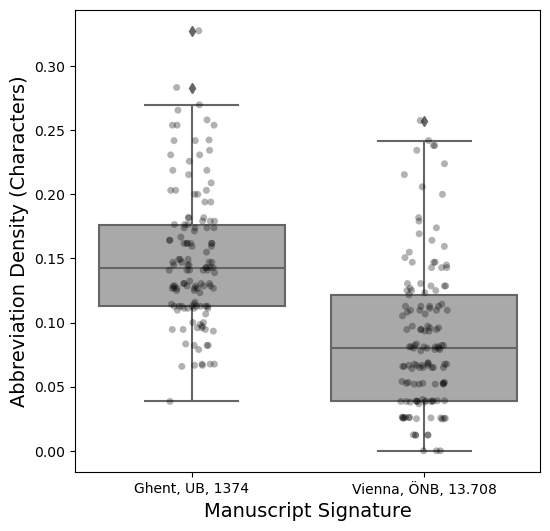

In [47]:
# Assuming 'densities' is your DataFrame
densities['segment_index'] = list(range(len(densities)))

# Create figure
fig, ax = plt.subplots(figsize=(6, 6))

# Boxplot
sns.boxplot(x='MS', y='density', data=densities, order=['Ghent, UB, 1374', 'Vienna, ÖNB, 13.708'],
            palette={'Ghent, UB, 1374': 'darkgray', 'Vienna, ÖNB, 13.708': 'darkgray'})
#ax.set_title("Abbreviation densities for 'Derde Martijn'", fontsize='14')
ax.set_ylabel('Abbreviation Density (Characters)', fontsize=14)
ax.set_xlabel('Manuscript Signature', fontsize=14)

# Stripplot (overlaying on the boxplot)
sns.stripplot(x='MS', y='density', data=densities, order=['Ghent, UB, 1374', 'Vienna, ÖNB, 13.708'],
              palette={'Ghent, UB, 1374': 'black', 'Vienna, ÖNB, 13.708': 'black'}, jitter=True, alpha=0.3)

plt.savefig('figures-and-tables/figure_5.png', dpi=1200, bbox_inches='tight')
plt.show()

It influences the usage of abbreviations very much! α uses almost twice as many abbreviations in the Ghent version.

In [48]:
# inspect specific segments:

segment_text = densities.iloc[265]['segment_text']
print(segment_text)
cnts = Counter(unicodedata.normalize('NFC', segment_text))
alph = np.sum([cnts[c] for c in set(letters)])
brev = np.sum([cnts[c] for c in set(brevigraphs)])
print('Abbreviation Density:', brev / alph)

se en̄ spelle Magic leeren alsict vertelle Mijn geloeue al bloet Daer ic bi scumen mach die helle Op
Abbreviation Density: 0.012345679012345678


## Exploratory scatterplots

We explore three different options when creating scatterplots:

- Option 1: use 'segments' as is

- Option 2: remove Saint-Petersburg, BAN, O 256 (and Brussels, KBR, 2979) to see how it influences Vienna, ÖBN, 12.857

- Option 3: only keep in α and β to see if two clusters get formed

#### Option 1: use 'segments' as is

In [49]:
# Create n-grams with the option to explicitly include brevigraphs or not
# and to incorporate graphemic or not

def ngrams(text, ngram_size=1, brevigraphs_only=True, graphemic=True):
    if graphemic:
        chars = [g for g in grapheme.graphemes(text) if g]
    else:
        chars = list(unicodedata.normalize('NFC', text))
    
    for idx in range(len(chars)-(ngram_size-1)):
        gram = text[idx:idx+ngram_size]
        if brevigraphs_only:
            brevigraph_present = False
            for char in gram:
                if char in brevigraphs:
                    brevigraph_present = True
            if brevigraph_present:
                yield gram
            else:
                continue
        else:
            yield ''.join(gram)
    
params = {'use_idf': True,
          'max_features': 100,
          'analyzer': partial(ngrams,
                              graphemic=True,
                              ngram_size=2,
                              brevigraphs_only=True),
          'min_df': 2}

vectorizer = TfidfVectorizer(**params)
BOW = vectorizer.fit_transform(segments['text']).toarray()
BOW = preprocessing.scale(BOW)
BOW.shape # amount of segments x number of features
BOW_df = pd.DataFrame(BOW, columns=vectorizer.get_feature_names_out())

print(BOW.shape) # amount of segments x number of features
BOW_df

(1493, 100)


,ā,ē,ī,ō,ꝟ,E,Wā,aē,aʼ,bē,...,ᵃm,ᵉ,ᵒe,ᵒt,ᵗ,ⁿ,ꝫ,ꝰ,,
0,0.482924,-0.603019,-0.063148,0.027403,-0.080521,0.859116,-0.912315,0.766615,-0.805243,0.598131,...,1.660656,-0.288152,-0.116778,-0.159258,-0.970814,-0.239145,-0.062339,-0.632981,-0.929656,0.669935
1,0.506921,-0.804191,-0.243394,-0.086634,-0.256092,1.219052,-0.912315,0.179707,-0.805243,0.079392,...,1.126881,-0.288152,2.876908,-0.653281,-0.970814,-0.239145,0.316807,-0.246710,-0.720914,0.790782
2,-0.704434,-0.804191,-0.167759,-0.111505,-0.438905,-0.459962,-0.912315,0.761763,-0.669199,2.750480,...,0.521198,-0.288152,2.213734,-0.653281,-0.970814,-0.239145,1.588769,-0.255363,-0.521525,-0.810334
3,-0.704434,-0.804191,-0.121582,-0.026871,-0.096409,-0.347430,-0.912315,0.685271,-0.805243,0.009611,...,-0.612250,-0.288152,2.650536,-0.653281,-0.970814,-0.239145,0.407912,-0.271147,0.048023,-0.585076
4,-0.180872,-0.804191,-0.665918,0.122737,-0.438905,1.491009,-0.491936,1.358993,-0.805243,2.313559,...,1.893327,-0.288152,2.391782,-0.217605,-0.970814,-0.239145,0.575023,-0.632981,-0.207892,1.625474
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1488,-0.704434,0.250092,-0.584207,-0.305754,-0.438905,-0.599369,-0.287786,0.133735,2.590334,-1.023637,...,-0.612250,0.020728,0.830410,1.288483,0.072989,-0.239145,-0.379487,2.591384,0.142621,-1.268971
1489,-0.704434,1.159134,-0.515418,-0.533082,-0.438905,0.485645,0.832216,2.289365,2.356440,2.273752,...,0.080943,-0.288152,0.011781,1.154730,0.487041,-0.239145,-0.026479,1.445510,0.817572,0.178664
1490,-0.704434,1.036726,-0.337439,-0.730067,-0.438905,0.462310,1.813959,0.680781,1.535200,0.213086,...,1.337674,-0.288152,1.304636,0.476911,-0.059506,-0.239145,-0.031530,2.615191,0.942680,-0.359315
1491,0.438096,-0.029881,-1.186135,-1.196867,-0.438905,-1.309772,-0.912315,-0.479738,-0.017710,-1.023637,...,0.481297,0.165557,-0.701338,-0.653281,-0.715276,-0.239145,-0.178438,4.467565,0.251632,-0.722976


In [50]:
# The most frequent 100 features

print(vectorizer.get_feature_names_out())

[' ā' ' ē' ' ī' ' ō' ' ꝟ' 'E\ue5dc' 'Wā' 'aē' 'aʼ' 'bē' 'dā' 'dē' 'dī'
 'dʼ' 'dꝫ' 'eʼ' 'e\ue5dc' 'gē' 'gᵒ' 'hā' 'hē' 'hʼ' 'hᵗ' 'hꝫ' 'iē' 'iʼ'
 'i\ue554' 'kē' 'kī' 'kʼ' 'lē' 'lʼ' 'mā' 'mē' 'mī' 'mʼ' 'mꝫ' 'nē' 'nᵗ'
 'oē' 'oʼ' 'oꝫ' 'pē' 'qᵃ' 'rē' 'sē' 'sō' 'tē' 'tʼ' 'uē' 'uʼ' 'vā' 'vʼ'
 'wā' 'wē' 'wʼ' 'ā ' 'ād' 'āt' 'ē ' 'ēd' 'ēn' 'ēs' 'ēt' 'ī ' 'īc' 'īd'
 'īg' 'īn' 'īt' 'ō ' 'ōd' 'ōg' 'ōm' 'ōs' 'ōt' 'ʼ ' 'ʼc' 'ʼd' 'ʼe' 'ʼh'
 'ʼk' 'ʼl' 'ʼm' 'ʼn' 'ʼr' 'ʼs' 'ʼt' 'ʼw' 'ᵃc' 'ᵃm' 'ᵉ ' 'ᵒe' 'ᵒt' 'ᵗ '
 'ⁿ ' 'ꝫ ' 'ꝰ ' '\ue554 ' '\ue5dc ']


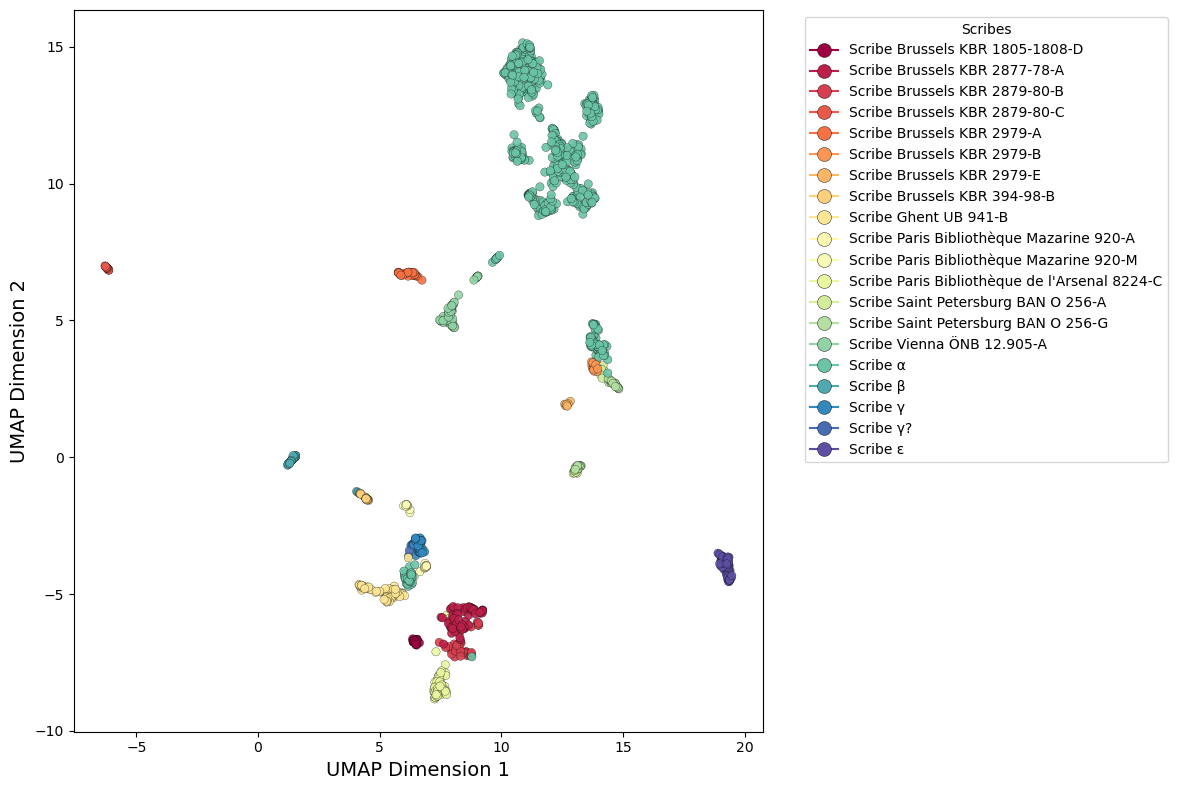

In [51]:
import umap.umap_ as umap

# Filter out scribes with less than 10 segments and exclude 'scribe3'
scribe_counts = segments['scribe'].value_counts()
filtered_scribes = scribe_counts[scribe_counts >= 10].index
filtered_segments = segments[segments['scribe'].isin(filtered_scribes)]

# Perform dimensionality reduction with PCA
pca_model = PCA(n_components=25)
X_pca = pca_model.fit_transform(BOW_df.loc[filtered_segments.index])

# Further reduction with UMAP
umap_model = umap.UMAP(n_components=2)
X_umap = umap_model.fit_transform(X_pca)

# Label encoding for scribes to color the scatter plot
label_encoder = LabelEncoder()
colors = label_encoder.fit_transform(filtered_segments['scribe'])

# Create a scatter plot with Matplotlib
plt.figure(figsize=(12, 8))
scatter = plt.scatter(X_umap[:, 0], X_umap[:, 1], c=colors, cmap='Spectral', alpha=0.9, edgecolor='black', linewidth=0.2)

# Creating a custom legend that matches the colors of the dots
scribe_labels = label_encoder.classes_
legend_handles = [plt.Line2D([0], [0], marker='o', color=scatter.cmap(scatter.norm(color)), label=f'Scribe {scribe}', markersize=10, markeredgecolor='black', markeredgewidth=0.3) for color, scribe in enumerate(scribe_labels)]

# Place the legend outside the plot on the right side, with a frame
plt.legend(handles=legend_handles, title="Scribes", bbox_to_anchor=(1.05, 1), loc='upper left', frameon=True)

# Adding titles and labels with enhanced fonts
plt.xlabel('UMAP Dimension 1', fontsize=14)
plt.ylabel('UMAP Dimension 2', fontsize=14)
plt.grid(False)
plt.tight_layout()
plt.savefig('figures-and-tables/scatterplot_1.svg', dpi=600, bbox_inches='tight')
plt.show()


Observations:

- γ and γ (?) are clustered closely together;
- Vienna, ÖBN, SN 65 is not located in the group of works written by α;
- Vienna, ÖBN, 12.857 is located close to the other works written by α, but not exactly in the cluster. It is clusters closely to Saint-Petersburg, BAN, O 256. The former was, however, copied from the latter (Hadewijch's works are also clustered together, one was copied from the other;
- Vienna, ÖBN, Cod. 13.708 is located inside the cluster.

#### Option 2: remove Saint-Petersburg, BAN, O 256 and Brussels, KBR, 2979

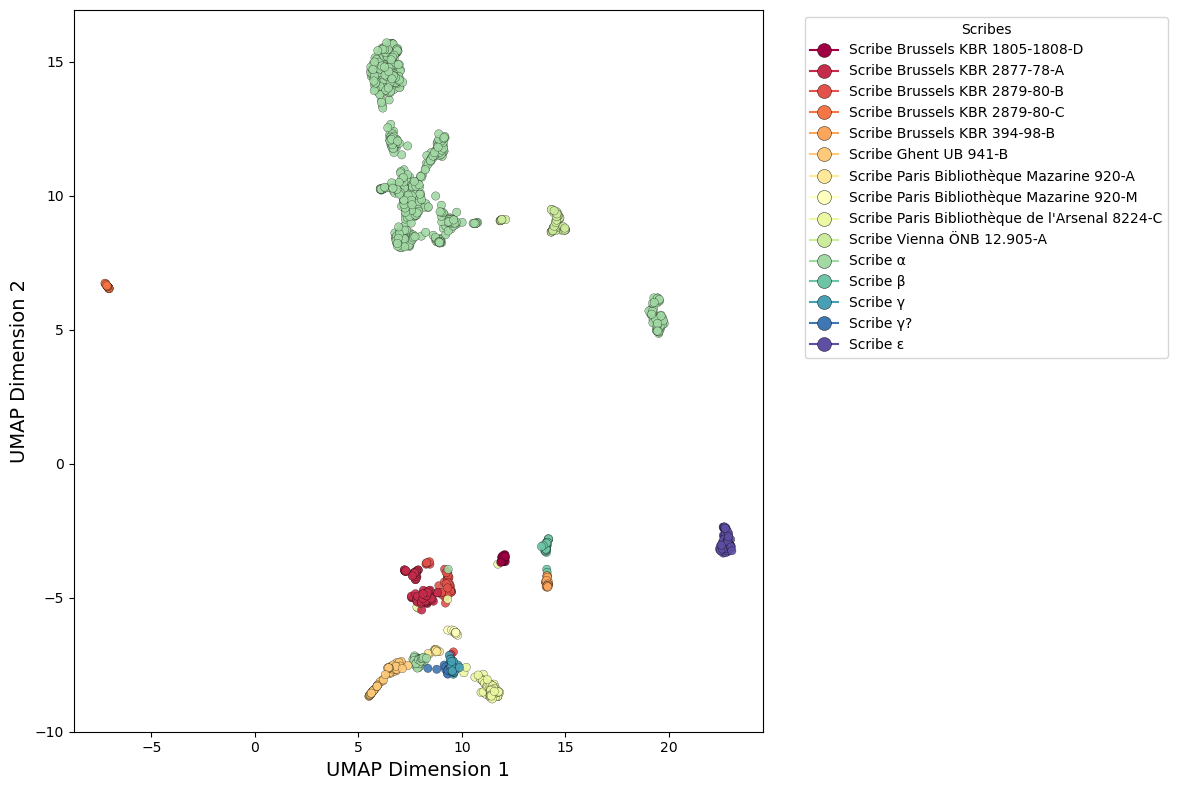

In [52]:
import umap.umap_ as umap

# Filter out scribes with less than 10 segments and exclude 'scribe3'
scribe_counts = segments['scribe'].value_counts()
filtered_scribes = scribe_counts[scribe_counts >= 10].index
# Exclude specific manuscripts based on the signatures
excluded_signatures = ['Brussels KBR 2979', 'Saint Petersburg BAN O 256']
filtered_segments = segments[
    (segments['scribe'].isin(filtered_scribes)) &
    (~segments['signature'].isin(excluded_signatures))
]

# Perform dimensionality reduction with PCA
pca_model = PCA(n_components=25)
X_pca = pca_model.fit_transform(BOW_df.loc[filtered_segments.index])

# Further reduction with UMAP
umap_model = umap.UMAP(n_components=2)
X_umap = umap_model.fit_transform(X_pca)

# Label encoding for scribes to color the scatter plot
label_encoder = LabelEncoder()
colors = label_encoder.fit_transform(filtered_segments['scribe'])

# Create a scatter plot with Matplotlib
plt.figure(figsize=(12, 8))
scatter = plt.scatter(X_umap[:, 0], X_umap[:, 1], c=colors, cmap='Spectral', alpha=0.9, edgecolor='black', linewidth=0.2)

# Creating a custom legend that matches the colors of the dots
scribe_labels = label_encoder.classes_
legend_handles = [plt.Line2D([0], [0], marker='o', color=scatter.cmap(scatter.norm(color)), label=f'Scribe {scribe}', markersize=10, markeredgecolor='black', markeredgewidth=0.3) for color, scribe in enumerate(scribe_labels)]

# Place the legend outside the plot on the right side, with a frame
plt.legend(handles=legend_handles, title="Scribes", bbox_to_anchor=(1.05, 1), loc='upper left', frameon=True)

# Adding titles and labels with enhanced fonts
plt.xlabel('UMAP Dimension 1', fontsize=14)
plt.ylabel('UMAP Dimension 2', fontsize=14)
plt.grid(False)
plt.tight_layout()
plt.savefig('figures-and-tables/scatterplot_2.svg', dpi=600, bbox_inches='tight')
plt.show()


Obersvations:
- Vienna, ÖBN, 12.857 is still located close to the cluster of α, but is not exactly part of it

#### Option 3: only keep in α and β 

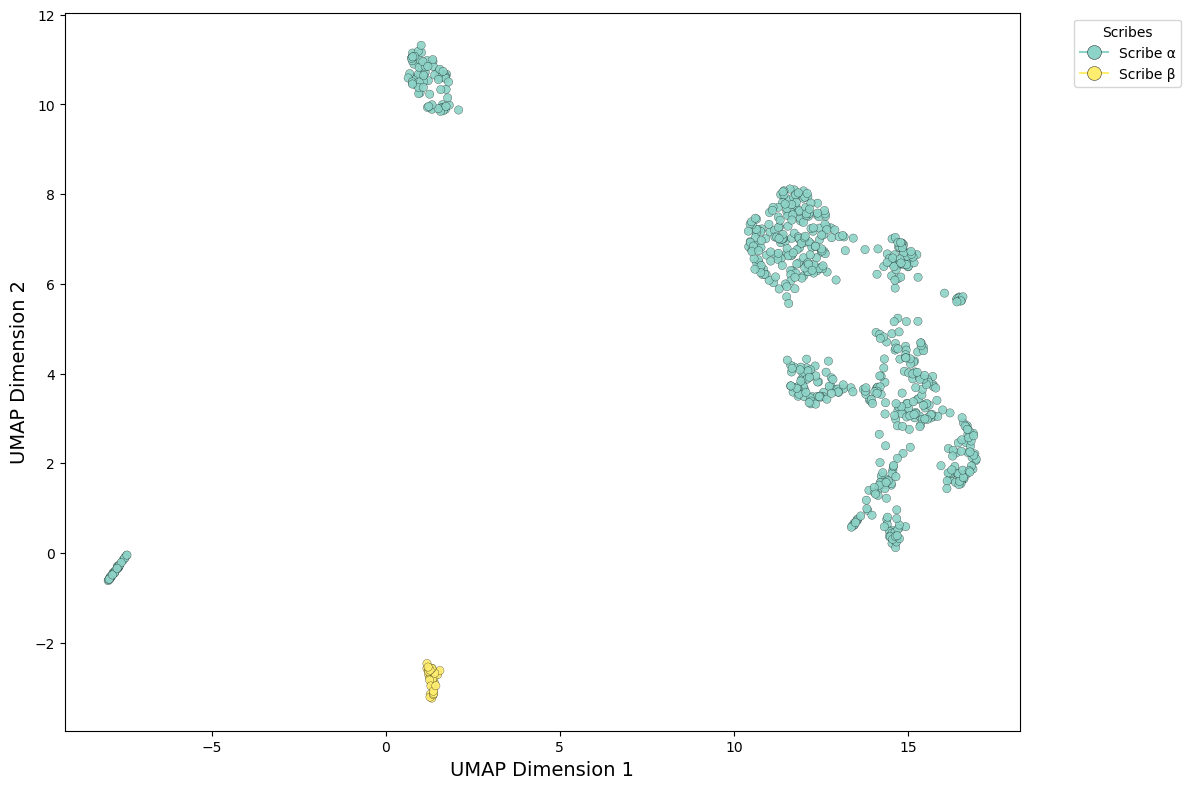

In [53]:
import umap.umap_ as umap

# Filter out scribes with less than 10 segments and exclude 'scribe3'
scribe_counts = segments['scribe'].value_counts()
filtered_scribes = scribe_counts[scribe_counts >= 10].index

# Exclude specific manuscripts based on the signatures and scribes
specific_scribes = ['α', 'β']
excluded_signatures = ['Saint Petersburg BAN O 256']
filtered_segments = segments[
    (segments['scribe'].isin(filtered_scribes)) &
    (~segments['signature'].isin(excluded_signatures)) &
    (segments['scribe'].isin(specific_scribes))
]

# Perform dimensionality reduction with PCA
pca_model = PCA(n_components=25)
X_pca = pca_model.fit_transform(BOW_df.loc[filtered_segments.index])

# Further reduction with UMAP
umap_model = umap.UMAP(n_components=2)
X_umap = umap_model.fit_transform(X_pca)

# Label encoding for scribes to color the scatter plot
label_encoder = LabelEncoder()
colors = label_encoder.fit_transform(filtered_segments['scribe'])

# Create a scatter plot with Matplotlib
plt.figure(figsize=(12, 8))
scatter = plt.scatter(X_umap[:, 0], X_umap[:, 1], c=colors, cmap='Set3', alpha=0.9, edgecolor='black', linewidth=0.2)

# Creating a custom legend that matches the colors of the dots
scribe_labels = label_encoder.classes_
legend_handles = [plt.Line2D([0], [0], marker='o', color=scatter.cmap(scatter.norm(color)), label=f'Scribe {scribe}', markersize=10, markeredgecolor='black', markeredgewidth=0.3) for color, scribe in enumerate(scribe_labels)]

# Place the legend outside the plot on the right side, with a frame
plt.legend(handles=legend_handles, title="Scribes", bbox_to_anchor=(1.05, 1), loc='upper left', frameon=True)

# Adding titles and labels with enhanced fonts
plt.xlabel('UMAP Dimension 1', fontsize=14)
plt.ylabel('UMAP Dimension 2', fontsize=14)
plt.grid(False)
plt.tight_layout()
plt.savefig('figures-and-tables/scatterplot_3.svg', dpi=600, bbox_inches='tight')
plt.show()


Observations: 
- β clusters together perfectly and is isolated from α;
- α clusters together overall, but Vienna, ÖNB, SN 65 is not in the cluster; 
- Vienna, ÖBN, 12.857 is also separated.

## Gamma (γ) classification

γ and γ(?) seemed to be closely related in option 1. Let's zoom in on them.

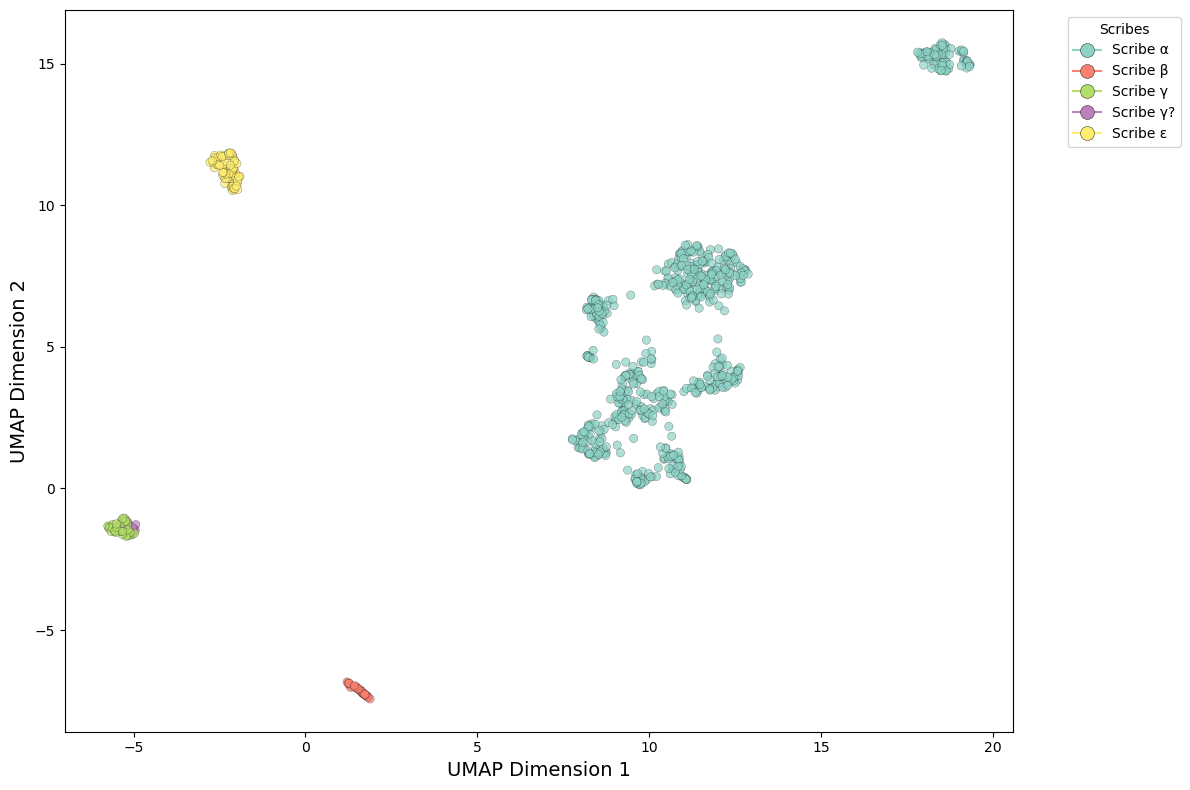

In [54]:
import umap.umap_ as umap

# Filter for specific scribes and exclude certain signatures and IDs
specific_scribes = ['α', 'β', 'γ', 'γ?', 'ε']
excluded_signatures = ['Saint Petersburg BAN O 256']
excluded_id = "Vienna ÖNB 65-II-α"

filtered_segments = segments[
    (segments['scribe'].isin(specific_scribes)) &
    (~segments['signature'].isin(excluded_signatures)) &
    (segments['id'] != excluded_id)
]

# Perform dimensionality reduction with PCA
pca_model = PCA(n_components=25)
X_pca = pca_model.fit_transform(BOW_df.loc[filtered_segments.index])

# Further reduction with UMAP
umap_model = umap.UMAP(n_components=2)
X_umap = umap_model.fit_transform(X_pca)

# Label encoding for scribes to color the scatter plot
label_encoder = LabelEncoder()
colors = label_encoder.fit_transform(filtered_segments['scribe'])

# Create a scatter plot with Matplotlib
plt.figure(figsize=(12, 8))
scatter = plt.scatter(X_umap[:, 0], X_umap[:, 1], c=colors, cmap='Set3', alpha=0.7, edgecolor='black', linewidth=0.2)

# Creating a custom legend that matches the colors of the dots
scribe_labels = label_encoder.classes_
legend_handles = [plt.Line2D([0], [0], marker='o', color=scatter.cmap(scatter.norm(color)), label=f'Scribe {scribe}', markersize=10, markeredgecolor='black', markeredgewidth=0.3) for color, scribe in enumerate(scribe_labels)]

# Place the legend outside the plot on the right side, with a frame
plt.legend(handles=legend_handles, title="Scribes", bbox_to_anchor=(1.05, 1), loc='upper left', frameon=True)

# Adding titles and labels with enhanced fonts
plt.xlabel('UMAP Dimension 1', fontsize=14)
plt.ylabel('UMAP Dimension 2', fontsize=14)
plt.grid(False)
plt.tight_layout()
plt.savefig('figures-and-tables/scatterplot_4.svg', dpi=600, bbox_inches='tight')
plt.show()


We replicate the previous analysis but now with an equal number of segments for each scribe (β's amount). Only γ? has less segments because there are no more available.

/var/folders/qv/jgq1ttws58g43xdmt2gthgth0000gn/T/ipykernel_16023/2152692716.py:47: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('Set3', len(scribe_labels))


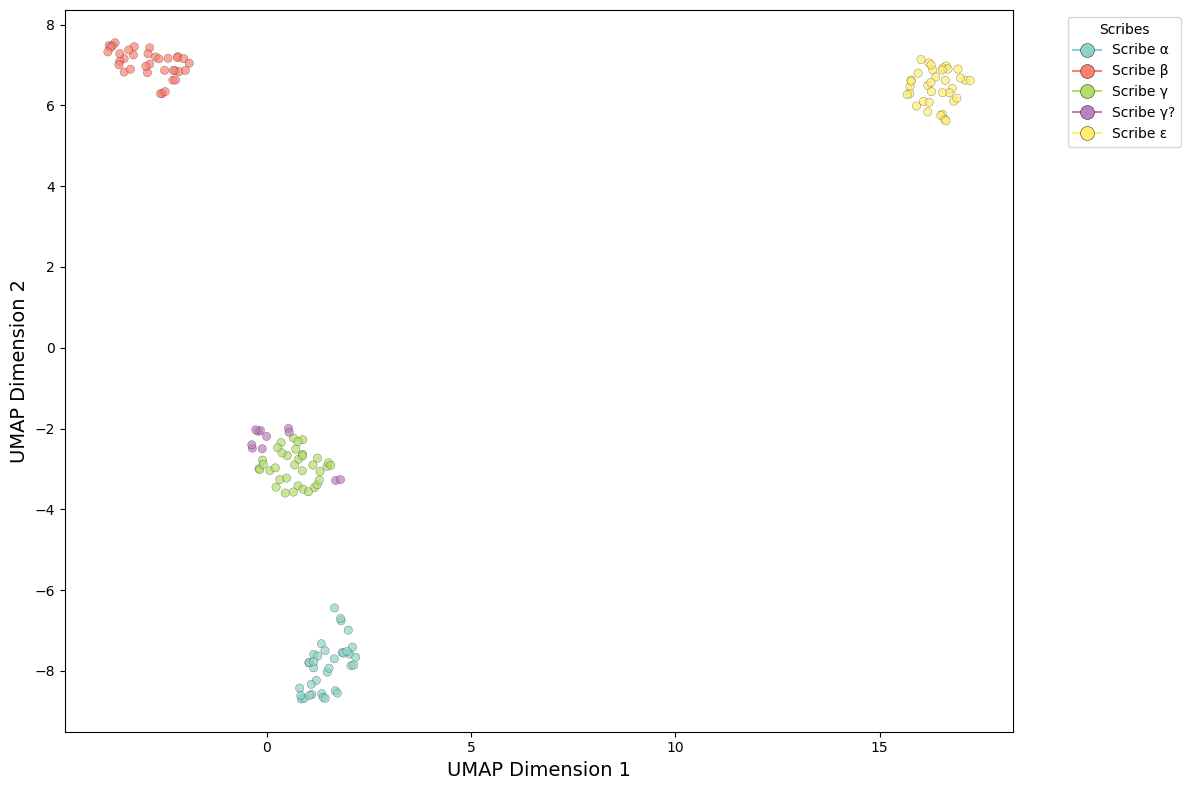

In [55]:
import umap.umap_ as umap

# Assuming 'filtered_segments' is your DataFrame
# Select the segments for scribe γ?
possible_gamma = filtered_segments[filtered_segments['scribe'] == 'γ?']

# Count the number of segments per scribe
scribes = filtered_segments.groupby('scribe').size()

# Downsample to the number of segments of the second-to-last fewest segments
beta_segments = scribes['β']  # Number of segments for scribe β
downsampled = filtered_segments[filtered_segments['scribe'] != 'γ?']
downsampled = downsampled.groupby('scribe').sample(n=beta_segments)

# Combine the downsampled segments with γ? segments
combined_segments = pd.concat([downsampled, possible_gamma])

# Feature Extraction with TF-IDF
vectorizer = TfidfVectorizer(**params)
BOW = vectorizer.fit_transform(combined_segments['text']).toarray()

# Scaling the BOW
scaler = StandardScaler()
BOW_scaled = scaler.fit_transform(BOW)

# Performing PCA for dimensionality reduction
pca = PCA(n_components=25)
X_pca = pca.fit_transform(BOW_scaled)

# Further reduction with UMAP
umap_model = umap.UMAP(n_components=2)
X_umap = umap_model.fit_transform(X_pca)

# Label encoding for scribes to color the scatter plot
label_encoder = LabelEncoder()
colors = label_encoder.fit_transform(combined_segments['scribe'])

# Creating a scatter plot with Matplotlib
plt.figure(figsize=(12, 8))
scatter = plt.scatter(X_umap[:, 0], X_umap[:, 1], c=colors, cmap='Set3', alpha=0.7, edgecolor='black', linewidth=0.2)
plt.xlabel('UMAP Dimension 1', fontsize=14)
plt.ylabel('UMAP Dimension 2', fontsize=14)
#plt.title('Scatterplot of Scribes Segments')

# Create a legend
scribe_labels = label_encoder.classes_
cmap = plt.cm.get_cmap('Set3', len(scribe_labels))
legend_handles = [plt.Line2D([0], [0], marker='o', color=cmap(i), label=f'Scribe {scribe}', markersize=10, markeredgewidth=0.3, markeredgecolor='black') for i, scribe in enumerate(scribe_labels)]
plt.legend(handles=legend_handles, title="Scribes", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.savefig('figures-and-tables/scatterplot_5.svg', dpi=600, bbox_inches='tight')
plt.tight_layout()
plt.show()


Observations:
- γ and γ(?) could be the same scribe.

## Outlier detection analysis

In this section, we are conducting an outlier detection analysis to explore the scribal style of scribe α. The objective is to identify any deviations in style within the segments attributed to this scribe.

In [56]:
# we select all segments attributed to scribe α
alpha = segments[segments['scribe'] == 'α'].copy()

# apply TF-IDF Vectorizer
BOW = vectorizer.fit_transform(alpha['text']).toarray()

# standardize the BOW data for uniformity
BOW = preprocessing.scale(BOW)
BOW.shape

(706, 100)

In [57]:
vectorizer.get_feature_names_out()

array([' ā', ' ē', ' ī', ' ō', 'Dꝫ', 'E\ue5dc', 'Vā', 'Wā', 'aē', 'aʼ',
       'aꝫ', 'bē', 'dā', 'dē', 'dī', 'dʼ', 'dꝫ', 'eʼ', 'e\ue5dc', 'gē',
       'gʼ', 'gᵒ', 'hā', 'hē', 'hʼ', 'hᵗ', 'hꝫ', 'iē', 'iʼ', 'i\ue554',
       'kē', 'kī', 'kʼ', 'lē', 'lʼ', 'mā', 'mē', 'mī', 'mʼ', 'mꝫ', 'nē',
       'nᵗ', 'oē', 'oʼ', 'oꝫ', 'pē', 'qᵃ', 'rē', 'sē', 'sō', 'tē', 'tʼ',
       'uē', 'uʼ', 'vā', 'vʼ', 'wā', 'wē', 'wʼ', 'ā ', 'ād', 'āt', 'ē ',
       'ēd', 'ēn', 'ēs', 'ēt', 'ī ', 'īc', 'īd', 'īg', 'īn', 'īt', 'ō ',
       'ōd', 'ōg', 'ōm', 'ōs', 'ōt', 'ʼ ', 'ʼc', 'ʼd', 'ʼe', 'ʼk', 'ʼl',
       'ʼm', 'ʼn', 'ʼr', 'ʼs', 'ʼt', 'ʼw', 'ᵃc', 'ᵃm', 'ᵒe', 'ᵒt', 'ᵗ ',
       'ꝫ ', 'ꝰ ', '\ue554 ', '\ue5dc '], dtype=object)

The BOW is created from the text of scribe α's segments, representing 706 segments with 100 features each.

In [58]:
# one-class SVM for outlier detection
one_class_svm = OneClassSVM().fit(BOW)
alpha['membership'] = one_class_svm.predict(BOW)

# counting membership values to identify outliers
alpha['membership'].value_counts()
alpha

,text,date,scribe,signature,id,translator,content,abbr_char,abbr_word,class,membership
608,Hier beghent de tafele hoemē vēdē sal de ewpē...,1387.5,α,Vienna ÖNB 12.857,Vienna ÖNB 12.857-II-α,NaN,perikopen,0.158278,0.342960,Rest,-1
613,huiꝰ lcōt corrigat librū qui valde īcorrectꝰ ē...,1387.5,α,Vienna ÖNB 65,Vienna ÖNB 65-II-α,NaN,horlogium,0.060043,0.176471,Rest,-1
614,e seide O mīlike iou ghelinc aen siet met ...,1387.5,α,Vienna ÖNB 65,Vienna ÖNB 65-II-α,NaN,horlogium,0.078235,0.231626,Rest,-1
615,er hande sijn bande die gode behaegt sal vā h...,1387.5,α,Vienna ÖNB 65,Vienna ÖNB 65-II-α,NaN,horlogium,0.066188,0.224138,Rest,-1
616,na hi ghewoenleec dē sone gods mꝫ dē name de...,1387.5,α,Vienna ÖNB 65,Vienna ÖNB 65-II-α,NaN,horlogium,0.071086,0.231651,Rest,-1
...,...,...,...,...,...,...,...,...,...,...,...
1486,iewe dinc Sint dꝫ ic kerstendoem ōtfīc Hebbic ...,1402.0,α,Vienna ÖNB 13.708,Vienna ÖNB 13.708-IV-α,NaN,sph2-2,0.096274,0.305846,Vienna ÖNB 13.708,1
1487,raet an nam Als hē dochte te siʼe orbarē Dit w...,1402.0,α,Vienna ÖNB 13.708,Vienna ÖNB 13.708-IV-α,NaN,sph2-2,0.090983,0.302349,Vienna ÖNB 13.708,1
1488,ōtfermēchede Es ontᵒest e vʼranesse mede Ser...,1402.0,α,Vienna ÖNB 13.708,Vienna ÖNB 13.708-IV-α,NaN,sph2-2,0.083912,0.287257,Vienna ÖNB 13.708,1
1489,ᵃ Van den keyser aureliꝰ ꝯmodꝰ lvi Dine tebere...,1402.0,α,Vienna ÖNB 13.708,Vienna ÖNB 13.708-IV-α,NaN,sph2-2,0.084031,0.254323,Vienna ÖNB 13.708,1


The One-Class SVM model classifies each segment as an inlier (1) or an outlier (-1).

In [59]:
# We will now have a closer look at production units as a 
# whole instead of just the segments.

# For every production unit, we train a model. The model is
# always trained on all of the production units written by 
# alhpa, except for 1. The model is then tested on the 1 
# work we left out during training to test whether it was 
# written by α or not. For every segment we test this
# separately. At the end, you get a percentage of which 
# segments of the production units are anomalies and which are
# not

# analyzing purity of production units
purity = []

# looping through each production unit of α
for prod_unit, group in alpha.groupby('id'):
    train_X = BOW[alpha['id'] != prod_unit]
    one_class_svm = OneClassSVM().fit(train_X)

    # testing on the excluded unit
    test_X = BOW[alpha['id'] == prod_unit]
    membership = one_class_svm.predict(test_X)
    membs = Counter(membership)
    purity.append([prod_unit, group.iloc[0]['signature'], membs[-1] / len(group), membs[1] / len(group)])

purity = pd.DataFrame(purity, columns=['unit', 'codex', '-1', '+1'])
purity

,unit,codex,-1,+1
0,Brussels KBR 1805-1808-I-α,Brussels KBR 1805-1808,0.370370,0.629630
1,Brussels KBR 2849-51-I-α,Brussels KBR 2849-51,1.000000,0.000000
2,Brussels KBR 2849-51-II-α,Brussels KBR 2849-51,1.000000,0.000000
3,Brussels KBR 2849-51-III-α,Brussels KBR 2849-51,0.900000,0.100000
4,Brussels KBR 2849-51-IV-α,Brussels KBR 2849-51,1.000000,0.000000
5,Brussels KBR 2849-51-V-α,Brussels KBR 2849-51,0.641026,0.358974
6,Brussels KBR 2849-51-VI-α,Brussels KBR 2849-51,0.384615,0.615385
7,Brussels KBR 2849-51-VII-α,Brussels KBR 2849-51,0.321429,0.678571
8,Brussels KBR 2905-09-II-α,Brussels KBR 2905-09,0.500000,0.500000
9,Brussels KBR 3093-95-I-α,Brussels KBR 3093-95,0.800000,0.200000


In [60]:
codex_svm_results = purity.groupby('codex').agg({'-1': 'mean', '+1': 'mean'}).sort_values('-1', ascending=False)
codex_svm_results

,-1,+1
codex,,
Vienna ÖNB 65,1.000000,0.000000
Vienna ÖNB 12.857,0.921053,0.078947
Brussels KBR 3093-95,0.788889,0.211111
Brussels KBR 2849-51,0.749581,0.250419
Ghent UB 1374,0.646111,0.353889
Brussels KBR 2905-09,0.500000,0.500000
Vienna ÖNB 13.708,0.481966,0.518034
Brussels KBR 1805-1808,0.370370,0.629630


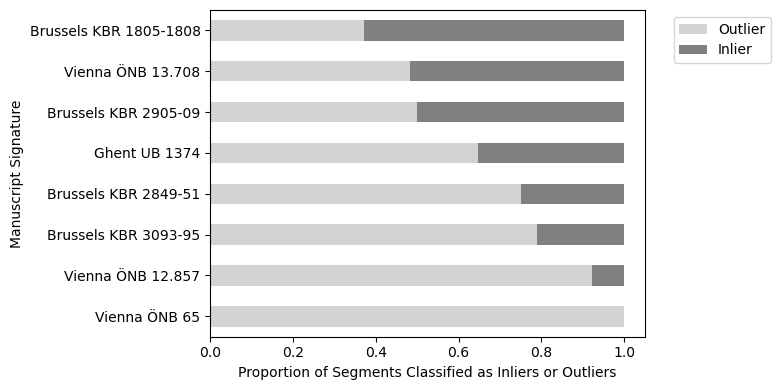

In [61]:
# Gray colours
colors = ['#d3d3d3', '#808080']

# Plotting a stacked bar chart with adjusted font size and layout
ax = codex_svm_results.plot(kind='barh', stacked=True, color=colors, figsize=(8, 4), fontsize=10)

# Setting plot title and labels
plt.xlabel('Proportion of Segments Classified as Inliers or Outliers', fontsize=10)
plt.ylabel('Manuscript Signature', fontsize=10)
plt.xticks(fontsize=10)

# Positioning the legend outside the plot on the right
plt.legend(labels=['Outlier', 'Inlier'], bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)

# Show plot
plt.tight_layout()
plt.savefig('figures-and-tables/outliers.png', format='png', dpi=1200)
plt.show()


This aggregation reveals which codices contain the most anomalies. Notably, Vienna, ÖBN, SN 65 stands out as a potential outlier, possibly indicating a divergence from α's usual style. 

#### Why is Vienna, ÖNB, SN 65 behaving strangely?

Next, we analyze the features that distinguish the segments written by the scribe of Vienna, ÖNB, SN 65 from the rest of his segments. This is done using a RandomForestClassifier and examining the feature importances.

This model is trained on the BOW representation of the segments, allowing it to recognize patterns and features unique to the Vienna manuscript.

After training, we calculate the **importance of each feature in distinguishing between the two classes**. This step is crucial for understanding which specific bigrams are most significant in differentiating Vienna, ÖNB, SN 65's segments from others.

We select the top features (based on their importance scores) and visualize them.

Finally, we create a df from BOW, allowing for a comparative box plot analysis. The box plots provide a visual representation of how the scores for these key features differ between the segments of Vienna, ÖNB, SN 65, and the rest of α's segments.

In [62]:
# create list called 'classes' that labels each segment of alpha as either 'Vienna ÖNB 65' or 'rest', based on the signature column
classes = ['Vienna ÖNB 65' if sig == 'Vienna ÖNB 65' else 'rest' for sig in alpha['signature']]

feature_names = vectorizer.get_feature_names_out()

# rfc is used to differentiate between the 'Vienna ÖNB 65' class and 'rest'
# the model is trained on the BOW representation of the text
forest = RandomForestClassifier(random_state=0)
forest.fit(BOW, classes)

# after training, the importance of each feature in distinguishing between the two classes is calculated
# the stdev of the importances across all trees in the forest is also calculated
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)

cutoff = 15
forest_importances = pd.Series(importances, index=feature_names)
std = pd.Series(std, index=feature_names)
forest_importances = forest_importances.sort_values(ascending=False).head(cutoff)[::-1]
std = forest_importances.loc[forest_importances.index].head(cutoff)[::-1]

forest_importances

e    0.013215
aē    0.015301
dʼ    0.019144
aʼ    0.019897
dꝫ    0.021078
ʼe    0.040890
nē    0.043899
nᵗ    0.055711
ꝫ     0.057662
i    0.058554
ʼ     0.067500
 ē    0.093928
     0.110974
 ī    0.127744
ī     0.132131
dtype: float64

/Users/carolinevandyck/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 42859 (\N{LATIN SMALL LETTER ET}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/carolinevandyck/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 58708 (\ue554) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


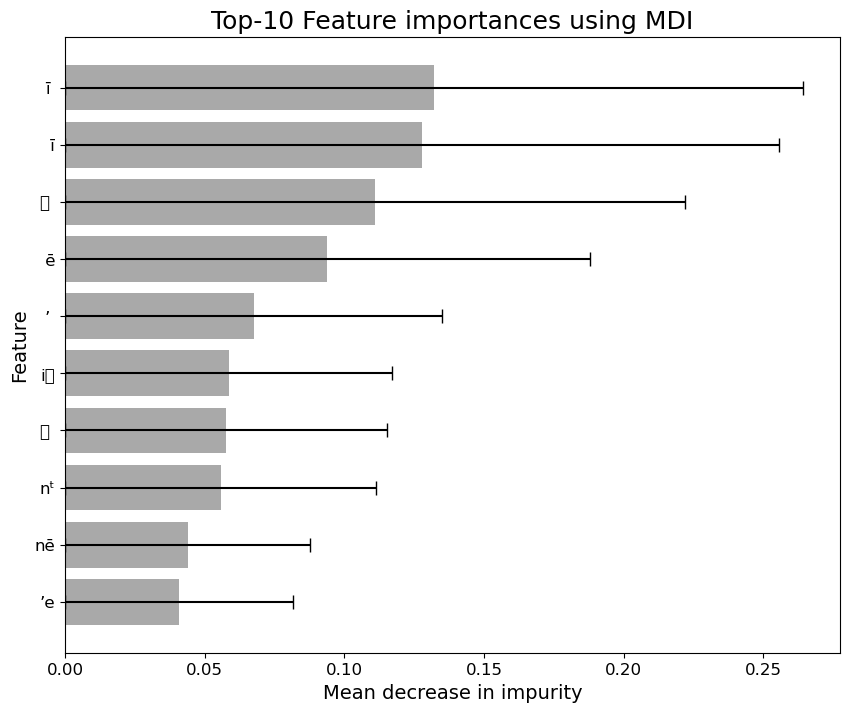

In [63]:
cutoff = 10
forest_importances = forest_importances.sort_values(ascending=False).head(cutoff)[::-1]
std = std.loc[forest_importances.index]

# Create a DataFrame from the feature importances and standard deviations
importance_data = pd.DataFrame({
    'feature': forest_importances.index,
    'importance': forest_importances.values,
    'importance_lower': forest_importances.values - std.values,
    'importance_upper': forest_importances.values + std.values
})

# Plotting
fig, ax = plt.subplots(figsize=(10, 8))

bars = ax.barh(importance_data['feature'], importance_data['importance'], color='darkgrey')

# Adding error bars
for bar, lower, upper in zip(bars, importance_data['importance_lower'], importance_data['importance_upper']):
    ax.errorbar(x=bar.get_width(), y=bar.get_y() + bar.get_height() / 2,
                xerr=[[bar.get_width() - lower], [upper - bar.get_width()]],
                color='black', capsize=5)

# Set labels and title
ax.set_xlabel('Mean decrease in impurity', fontsize=14)
ax.set_ylabel('Feature', fontsize=14)
ax.set_title('Top-10 Feature importances using MDI')

# Customize fonts
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('Top-10 Feature importances using MDI', fontsize=18)

plt.show()

In [64]:
BOW = pd.DataFrame(BOW, columns=feature_names)
BOW = BOW[forest_importances.index]
BOW.index = classes
BOW

,ʼe,nē,nᵗ,ꝫ,i,ʼ,ē,,ī,ī
rest,-0.983364,-0.880936,-0.482167,-0.481896,-0.374902,1.442018,-0.811674,-0.172574,0.061652,-0.081621
Vienna ÖNB 65,-1.639023,2.061700,-1.566834,-1.797319,-1.837861,-2.068900,-1.453264,-1.711414,-1.707973,-1.980575
Vienna ÖNB 65,-1.904579,4.177007,-1.566834,-1.877401,-1.837861,-1.957174,-1.792580,-1.711414,-2.101871,-2.195660
Vienna ÖNB 65,-1.904579,1.827867,-1.566834,-1.483643,-1.837861,-2.370591,-1.792580,-1.711414,-1.753795,-1.815531
Vienna ÖNB 65,-1.671797,3.720557,-1.566834,-1.374542,-1.591412,-1.515894,-1.792580,-1.711414,-1.756587,-1.630041
...,...,...,...,...,...,...,...,...,...,...
rest,-0.472967,0.326368,-0.844424,-1.257591,0.110861,-0.541252,-0.485972,0.082160,0.324993,0.454681
rest,-1.354874,1.565775,-0.488103,0.359720,-0.479905,0.067769,-0.621934,-0.334037,-1.150600,-1.156792
rest,0.352081,-0.198861,0.027403,-0.844278,-0.165446,1.252540,-0.639196,-0.580525,-1.097682,-1.099001
rest,-1.694194,-0.343365,0.167159,-0.412587,-0.278697,0.202301,0.357980,0.133625,-1.009651,-1.002864


In [65]:
bow = pd.melt(BOW, value_vars=BOW.columns, ignore_index=False, var_name='abbreviation', value_name='score')
bow = bow.reset_index()
bow['origin'] = bow['index']
bow

,index,abbreviation,score,origin
0,rest,ʼe,-0.983364,rest
1,Vienna ÖNB 65,ʼe,-1.639023,Vienna ÖNB 65
2,Vienna ÖNB 65,ʼe,-1.904579,Vienna ÖNB 65
3,Vienna ÖNB 65,ʼe,-1.904579,Vienna ÖNB 65
4,Vienna ÖNB 65,ʼe,-1.671797,Vienna ÖNB 65
...,...,...,...,...
7055,rest,ī,0.454681,rest
7056,rest,ī,-1.156792,rest
7057,rest,ī,-1.099001,rest
7058,rest,ī,-1.002864,rest


findfont: Font family 'Cardo' not found.
findfont: Font family 'Cardo' not found.
findfont: Font family 'Cardo' not found.
findfont: Font family 'Cardo' not found.
findfont: Font family 'Cardo' not found.
/var/folders/qv/jgq1ttws58g43xdmt2gthgth0000gn/T/ipykernel_16023/4129411289.py:25: UserWarning: Glyph 42859 (\N{LATIN SMALL LETTER ET}) missing from current font.
  plt.savefig('figures-and-tables/boxplot.pdf', dpi=600, bbox_inches='tight')
findfont: Font family 'Cardo' not found.
/var/folders/qv/jgq1ttws58g43xdmt2gthgth0000gn/T/ipykernel_16023/4129411289.py:25: UserWarning: Glyph 58708 (\ue554) missing from current font.
  plt.savefig('figures-and-tables/boxplot.pdf', dpi=600, bbox_inches='tight')
findfont: Font family 'Cardo' not found.
findfont: Font family 'Cardo' not found.
findfont: Font family 'Cardo' not found.
findfont: Font family 'Cardo' not found.
findfont: Font family 'Cardo' not found.
findfont: Font family 'Junicode' not found.
findfont: Font family 'Junicode' not found

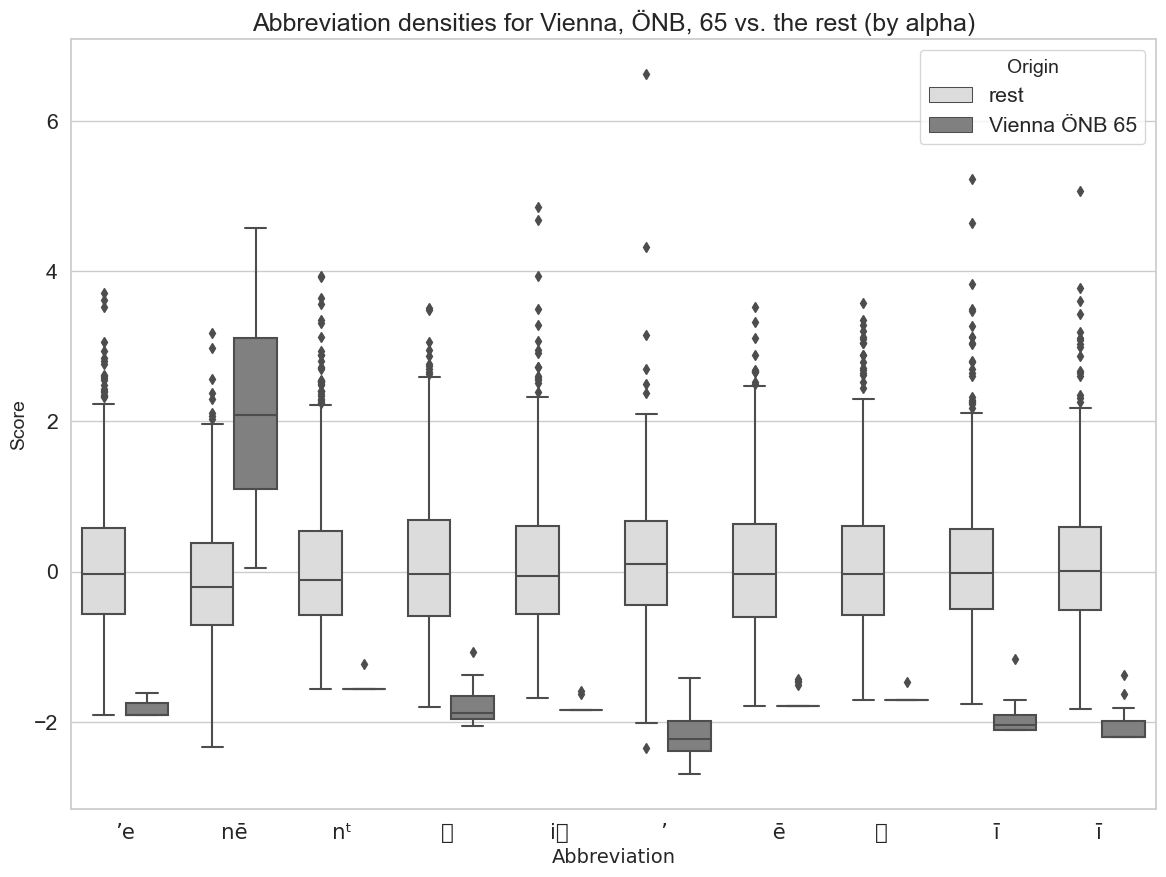

In [66]:
# Set the font style
# set cardo to be the default font for special glyphs
plt.rcParams["font.family"] = "Cardo"
sns.set(style="whitegrid", font_scale=1.4)

# Define a custom color palette with two colors using names
custom_palette = ["gainsboro", "gray"]

# Plotting
plt.figure(figsize=(14, 10))

# Create a boxplot with 'abbreviation' on the x-axis, 'score' on the y-axis, and 'origin' as hue
sns.boxplot(x='abbreviation', y='score', hue='origin', data=bow, palette=custom_palette)

# Set labels and title
plt.xlabel('Abbreviation', fontsize=14, fontname='Junicode')
plt.ylabel('Score', fontsize=14)
plt.title('Abbreviation densities for Vienna, ÖNB, 65 vs. the rest (by alpha)', fontsize=18)

# Show the legend
plt.legend(title='Origin', title_fontsize='14')

# Set the x-axis labels to use the Junicode font
plt.xticks(fontname='Cardo')
plt.savefig('figures-and-tables/boxplot.pdf', dpi=600, bbox_inches='tight')
plt.show()

Abbreviations are almost absent!